This notebook will begin with the exploration of the Pseudo-Huber loss function.<br>
I chose this function, because of its ability to adapt to the wide range of prediction errors that will be encountered.<br>
The target values in the dataset, movie revenue, range in scale from under 10 dollars to nearly 10 billion dollars.<br>
This loss function has a hyperparameter, delta, that needs to be selected, before it can be used.<br>
The delta value sets a threshold, where the behavior of the loss function changes from a squared to an absolute loss.<br>
This will prevent the models from being heavily penalized for making predictions that are either very large or small.<br>
After this value is selected to best fit the data, I will optimize a regression model by using boosted decision trees.<br>
I will be using the XGBoost library, along with the informed search algorithm, Hyperopt.<br>
Hyperopt performs a Bayesian search method.<br>
This is where the selection of hyperparameters to try are chosen by the results of the previous searches.<br>
The goal of this notebook is to optimize many hyperparameters to find the best XGBoost model for predicting on the data.

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))
from IPython.display import clear_output

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict
from itertools import product

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


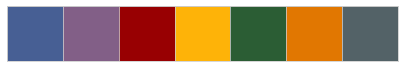

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# set option for palette argument
my_palette = ['xkcd:' + c for c in mp.my_colors]

In [6]:
# read in actor dataset
df = pd.read_json('../data/capstone2_optimized_target_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11610, 28)

In [8]:
# separate data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

In [9]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

 > **Pseudo-Huber Loss**

For this analysis, I will use a custom optimization function to perform gradient descent.<br>
XGBoost needs a twice differentiable function to optimize.<br>
My target has a broad range of scale, which will give both large and small errors.<br>
The Huber loss behaves like Mean Squared Error (MSE) for small errors and Mean Absolute Error (MAE) for large ones.<br>
Since it is not twice differentiable, as is required by XGBoost, I will need to use the Pseudo-Huber loss, instead.<br>
Given this dataset, I believe this choice is better suited to optimize the model selection over either MSE or MAE, alone.

The Pseudo-Huber loss has a hyperparameter, delta, that needs to be chosen.<br>
This will determine the region where the function will switch between behaving like either MSE or MAE.

In [10]:
def huber(loss, delta):
    """Return Huber loss from original loss and chosen delta"""
    loss = np.abs(loss)
    flag = loss > delta
    huber_loss = (~flag) * (0.5 * loss ** 2) - (flag) * delta * (0.5 * delta - loss)
    
    return huber_loss

In [11]:
def plot_losses(losses):
    """Plot original error and returned Huber loss"""
    # get MSE
    mse_loss = losses ** 2
    plt.plot(losses, mse_loss, label='MSE', color='k', linestyle='-.')
    # get MAE
    mae_loss = np.abs(losses)
    plt.plot(losses, mae_loss, label='MAE', color='k', linestyle='--')
    
    for delta in range(100, 900 + 1, 200):
        # get Huber loss
        huber_loss = huber(losses, delta)
        # plot losses
        sns.lineplot(losses, huber_loss, label=delta, palette=my_palette)
    
    # set scale to best display chosen range of losses
    y_scale = int(np.log10(losses[-1]))
    y_limit = losses[-1] ** 2 / (2 * 10 ** (y_scale - 3))
    plt.ylim(0, y_limit)
    
    plt.xlabel('Error')
    plt.ylabel('Huber Loss')
    
    plt.legend(title='Delta', loc=6, bbox_to_anchor=(1, 0.5))
    plt.title('Model Error vs. Huber Loss')

Here, I will show the effects on the errors of using different values for delta.<br>
The colored lines will range between the two black lines, which represent the traditional losses.<br>
It is important to note the scales of the plots.

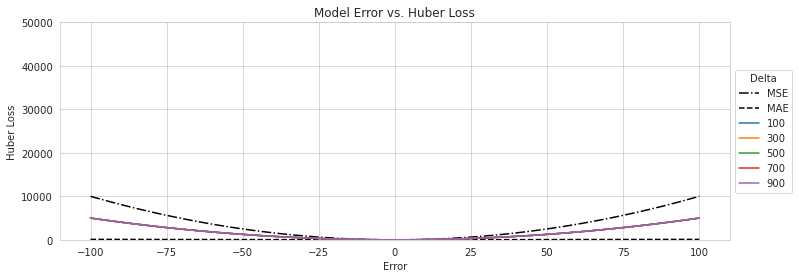

In [12]:
# observe regularization of small errors using Huber loss
plot_losses(np.linspace(-1e2, 1e2, 100))

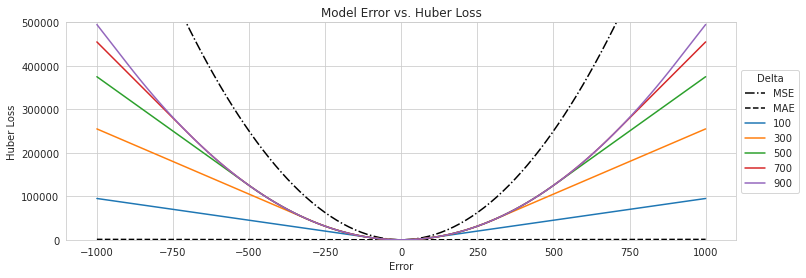

In [13]:
# observe regularization of moderate errors using Huber loss
plot_losses(np.linspace(-1e3, 1e3, 100))

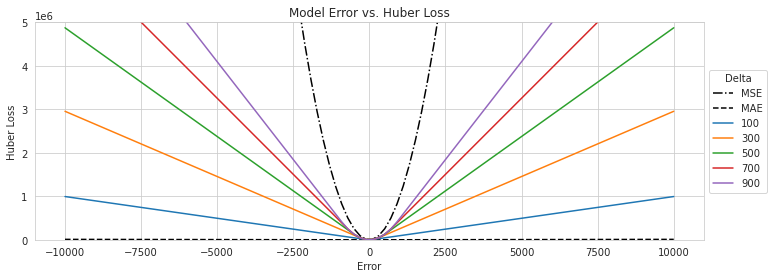

In [14]:
# observe regularization of large errors using Huber loss
plot_losses(np.linspace(-1e4, 1e4, 100))

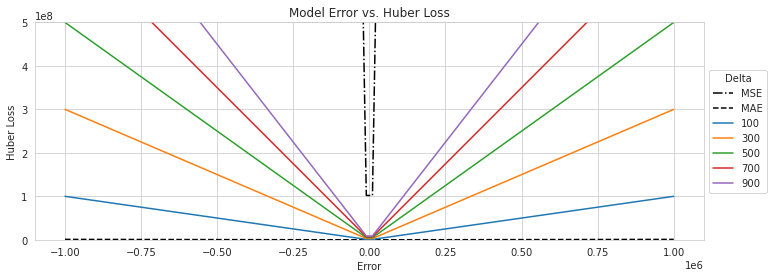

In [15]:
# observe regularization of very large errors using Huber loss
plot_losses(np.linspace(-1e6, 1e6, 100))

Now, I will built my custom loss function, which XGBoost will use to perform the gradient descent.<br>
XGBoost requires both the gradient and the hessian of the function, as well.

In [16]:
def gradient(labels, preds, delta):
    """Return gradient of Pseudo-Huber loss"""
    errors = preds - labels
    scale = delta**2 + errors**2
    grad = errors * np.power(scale, -0.5)
    
    return grad

In [17]:
def hessian(labels, preds, delta):
    """Return hessian of Pseudo-Huber loss"""
    errors = labels - preds
    scale = delta**2 + errors**2
    hess = delta**2 * np.power(scale, -3/2.0)
    
    return hess

In [18]:
def pseudo_huber(preds, dtrain, delta):
    """Return gradient and hessian of Pseudo-Huber loss"""
    labels = dtrain.get_label()
    grad = gradient(labels, preds, delta=delta)
    hess = hessian(labels, preds, delta=delta)
    
    return grad, hess

I will create a custom evaluation funtion that will be used to enable early stopping of the boosting rounds during training.<br>
As taking the MSE will give larger values, I will use MAE for faster convergence.<br>
The data has been optimized by having its target variable transformed using the log scale.<br>
I need to convert the test data and model predictions back to dollar amounts, before computing the evaluation errors.

In [19]:
def eval_error(preds, dtrain):
    """Return mean absolute error in dollar values"""
    labels = dtrain.get_label()
    # transform data from log form
    errors = np.exp(preds) - np.exp(labels)
    mae_dollars = np.mean(np.absolute(errors))
    
    return '$_mae', mae_dollars

Below, I will create a function to train an XGBoost model on some data.<br>
It will return the trained model and the training evaluation errors.

I am choosing to set the maximum number of boosting round to be 500, with an early stopping limit of 100.<br>
While these are large values for training boosted models, I want to give the models some room to explore, for now.

In [20]:
def get_xgbr_train(dtrain, dtest, delta, processor_type, 
                   params={}, max_boost_round=500, early_stopping_limit=100):
    """Return trained Learning API XGBoost model and training results"""
    # instantiate empty dict to store evaluation metrics
    results = {}
    
    # add operational parameters
    params['disable_default_eval_metric'] = 1
    params['tree_method'] = processor_type
    
    # set evaluation data
    watchlist = [(dtrain, 'train'), (dtest, 'test')]

    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)
    
    # instantiate regressor
    model = xgb.train(params, dtrain, num_boost_round=max_boost_round, evals=watchlist, 
                      obj=train_pseudohuber, feval=eval_error, 
                      early_stopping_rounds=early_stopping_limit, 
                      evals_result=results, verbose_eval=False)
            
    return model, results

First, I will select an optimum delta hyperparameter.<br>
The choice will depend on the errors produced from a base model, before tuning any of its hyperparameters.

To show the variations in errors that result from different delta values, I will create some residual plots.

In [21]:
def plot_delta_predictions(features, target, deltas):
    """Plot observed target vs. predictions for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    
    plt.ylim(0, 1.4e9)
    
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.scatterplot(labels, preds, label=delta)
        sns.regplot(labels, preds, scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.legend(title='Delta')
    plt.title("Ground Truth vs Predicted")

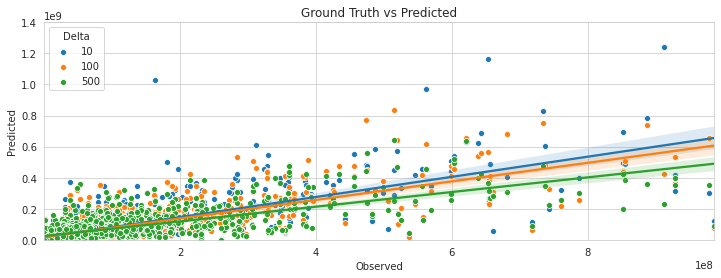

In [22]:
# plot observed target vs. predictions for a range of deltas
plot_delta_predictions(X_train, y_train, [10, 100, 500])

The line where delta has a value of 10 produces a more accurate model.<br>
This is true, because it is closer to 45 degrees than the others, which would be the line created by perfect predictions..

In [23]:
def plot_delta_residuals(features, target, deltas):
    """Plot predictions vs.residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.residplot(preds, labels, label=delta, lowess=True, 
                      scatter_kws={'s':10}, line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.legend(title='Delta')
    plt.title("Predicted vs Residuals")

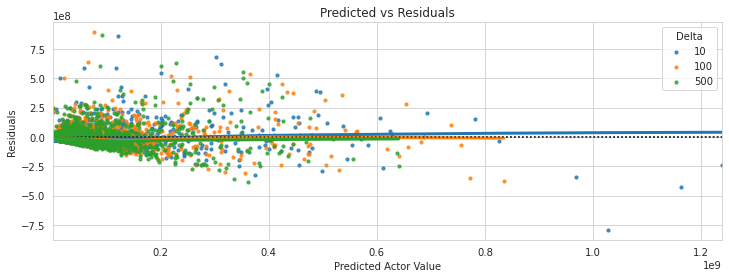

In [24]:
# plot predictions vs. residuals for a range of deltas
plot_delta_residuals(X_train, y_train, [10, 100, 500])

Judging by the equal distribution of the residuals about 0, heteroscedasticity is not a problem with any choice of delta.

In [25]:
def plot_delta_residual_distribution(features, target, deltas):
    """Plot distribution of residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors        
        sns.distplot(labels - preds, label=delta, bins=300, axlabel='Residuals')

    plt.ylabel('Frequency')
    
    plt.legend(title='Delta')
    plt.title('Distribution of Residuals')

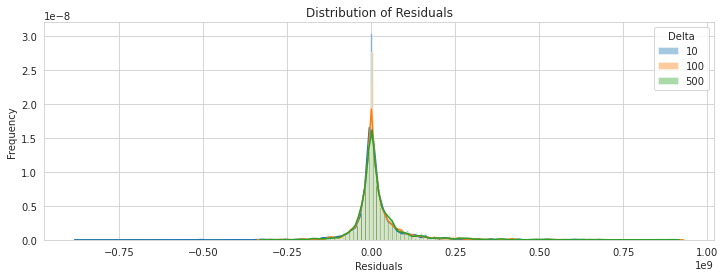

In [26]:
# plot residuals distribution for a range of deltas
plot_delta_residual_distribution(X_train, y_train, [10, 100, 500])

Aside from the extreme outliers, the distribution of residuals appers fairly normal, regardless of the choice of delta.

Accuracy and performace can vary between different training methods.<br>
I will create a custon cross validation (CV) function from scratch to compare with the built in XGBoost CV.<br>
I will compare the differences between using CPU and GPU computing, as well.

This is the custom cross validation function, built from scratch.

In [27]:
def get_scratch_cv(features, target, 
                   delta, processor_type, params={}, 
                   max_boost_round=500, early_stopping_limit=100):
    """Return CV results with statistics from best iteration of each fold"""
    # create default dict to hold MAE statistics from each fold
    cv_results = defaultdict(list)
    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    
    # split data and run 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        
        # convert data for faster training
        dtrain = xgb.DMatrix(data=train_features, label=train_target, nthread=-1)
        dtest = xgb.DMatrix(data=test_features, label=test_target, nthread=-1)
        
        # instantiate and fit model
        model, results = get_xgbr_train(
            dtrain, dtest, delta, processor_type, params, 
            max_boost_round, early_stopping_limit)
        
        # get iteration with best test MAE
        best_iter = model.best_iteration
        # get training MAE from iteration of best test MAE
        train_mae = results['train']['$_mae'][best_iter]
        # get best test MAE
        test_mae = results['test']['$_mae'][best_iter]
        # get boosting round with best CV test MAE average
        n_boost = best_iter + 1 
        
        # save fold results to default dict
        cv_results['test_mae'].append(test_mae)
        cv_results['train_mae'].append(train_mae)
        cv_results['n_boost'].append(n_boost)

    return cv_results

Here is the function which uses XGBoost's built in cross validation method.

In [28]:
def get_xgbr_cv(features, target, delta, processor_type, 
                params={}, max_boost_round=500, early_stopping_limit=100):
    """Return Learning API XGBoost CV evaluation results"""
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)

    # convert data for faster training
    dtrain = xgb.DMatrix(data=features, label=target, nthread=-1)

    # add operational parameters
    params['disable_default_eval_metric'] = 1
    params['tree_method'] = processor_type

    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)

    # create dict to hold scores for best boosting round
    cv_results = {}
    
    # get cross validation history
    cv_hist = xgb.cv(params, dtrain, num_boost_round=max_boost_round, nfold=10, 
                     folds=folds, obj=train_pseudohuber, feval=eval_error, 
                     early_stopping_rounds=early_stopping_limit, 
                     verbose_eval=False, seed = 27)
    
    # get index of boosting round with best CV test MAE average
    best_index = cv_hist['test-$_mae-mean'].argmin()
    # get best CV test MAE average
    test_mae = cv_hist.iloc[best_index]['test-$_mae-mean']
    # get CV training MAE average from best boosting round
    train_mae = cv_hist.iloc[best_index]['train-$_mae-mean']
    # get boosting round with best CV test MAE average
    n_boost = best_index + 1
    
    # save results to default dict
    cv_results['test_mae'] = test_mae
    cv_results['train_mae'] = train_mae
    cv_results['n_boost'] = n_boost

    return cv_results

For a quick peak at what results I'm looking to get, I'll show a few examples, using the custom CV function.

First, I'll search for the best delta using GPU power.

From the viewing residual plots, I know that I want to explore the smallest deltas possible.<br>
It should be noted that I can't use integers lower than 8, without the calculations blowing up.

In [29]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

In [30]:
def print_cv_mae(features, target, delta, cv_type, processor_type):
    """Print average mean absolute errors and boosting rounds from 10 fold cv"""
    # get results from 10 fold cross validation
    cv_results = cv_type(features, target, delta, processor_type)
    # get overall average test MAE of the 10 folds
    test_mean = np.mean(cv_results['test_mae'])
    # get overall average training MAE of the 10 folds
    train_mean = np.mean(cv_results['train_mae'])
    # get average number of boosting rounds
    n_boost = np.mean(cv_results['n_boost'])
    
    print('Delta: {}\nTest MAE: {}\nTraining MAE: {}\nBoost Rounds: {}\n'\
          .format(delta, make_money(test_mean), 
                  make_money(train_mean), int(np.round(n_boost))))

In [31]:
%%time
# observe average custom CV scores for delta=8
print_cv_mae(X_train, y_train, 8, get_scratch_cv, 'gpu_hist')

Delta: 8
Test MAE: $36,553,070.80
Training MAE: $19,211,918.05
Boost Rounds: 205

CPU times: user 11.9 s, sys: 83.1 ms, total: 12 s
Wall time: 12 s


In [32]:
%%time
# observe average custom CV scores for delta=9
print_cv_mae(X_train, y_train, 9, get_scratch_cv, 'gpu_hist')

Delta: 9
Test MAE: $37,037,894.80
Training MAE: $17,890,009.90
Boost Rounds: 231

CPU times: user 13.1 s, sys: 96.1 ms, total: 13.2 s
Wall time: 13.2 s


In [33]:
%%time
# observe average custom CV scores for delta=10
print_cv_mae(X_train, y_train, 10, get_scratch_cv, 'gpu_hist')

Delta: 10
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Boost Rounds: 221

CPU times: user 12.7 s, sys: 96.2 ms, total: 12.8 s
Wall time: 12.9 s


In [34]:
%%time
# observe average custom CV scores for delta=11
print_cv_mae(X_train, y_train, 11, get_scratch_cv, 'gpu_hist')

Delta: 11
Test MAE: $36,372,526.80
Training MAE: $17,667,692.90
Boost Rounds: 262

CPU times: user 13.5 s, sys: 119 ms, total: 13.6 s
Wall time: 13.6 s


The best value is 10.<br>
Now, I'll search using CPU computation.

In [35]:
%%time
# observe average custom CV scores for delta=8
print_cv_mae(X_train, y_train, 8, get_scratch_cv, 'auto')

Delta: 8
Test MAE: $35,966,674.40
Training MAE: $14,962,411.90
Boost Rounds: 304

CPU times: user 5min 16s, sys: 12.5 s, total: 5min 29s
Wall time: 13.9 s


In [36]:
%%time
# observe average custom CV scores for delta=9
print_cv_mae(X_train, y_train, 9, get_scratch_cv, 'auto')

Delta: 9
Test MAE: $36,851,526.20
Training MAE: $18,883,824.80
Boost Rounds: 238

CPU times: user 4min 25s, sys: 10.6 s, total: 4min 36s
Wall time: 11.7 s


In [37]:
%%time
# observe average custom CV scores for delta=10
print_cv_mae(X_train, y_train, 10, get_scratch_cv, 'auto')

Delta: 10
Test MAE: $36,175,629.20
Training MAE: $18,874,769.40
Boost Rounds: 242

CPU times: user 5min 38s, sys: 16.7 s, total: 5min 55s
Wall time: 15.4 s


The best delta value to use with a CPU is 8.

CPU use appears to take more time than using the GPU.

Now, I will plot the CV errors over a larger range of delta values, while using the four different computation methods.

In [38]:
def test_deltas(features, target, delta_min, delta_max, cv_type, processor_type):
    """Return DataFrame with CV results over range of Pseudo-Huber deltas"""
    # create iterable of deltas
    deltas = np.arange(delta_min, delta_max + 1, 1)
    #create default dict to store CV results
    revenue_dict = defaultdict(list)
    
    # create ten delta values to test
    for delta in deltas:
        print('Working on Delta = ', delta, '...')
        clear_output(wait=True)
        
        # create default dict to hold average CV scores
        cv_averages = defaultdict(list)
        
        # get results from 10 fold cross validation
        cv_results = cv_type(features, target, delta, processor_type)

        # create list of keys from dict returned from selected CV function
        keys = list(cv_results.keys())
        
        # get overall average scores and number of boosting rounds of the 10 folds
        test_mae_ave = np.mean(cv_results['test_mae'])
        train_mae_ave = np.mean(cv_results['train_mae'])
        n_estimator_ave = int(np.mean(cv_results['n_boost']))
        
        # store results for final comparison
        revenue_dict[delta].append(test_mae_ave)
        revenue_dict[delta].append(train_mae_ave)
        revenue_dict[delta].append(n_estimator_ave)
        
    print('Finished all {} deltas.'.format(len(deltas)))
    
    # transfer results to DataFrame
    results_df = pd.DataFrame(
        revenue_dict, index=keys).transpose().sort_values('test_mae')
    
    return results_df

In [39]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on CPU
scr_cpu_results_df = test_deltas(X_train, y_train, 8, 20, get_scratch_cv, 'auto')
scr_cpu_results_df

Finished all 13 deltas.
CPU times: user 56min 45s, sys: 2min 9s, total: 58min 54s
Wall time: 2min 28s


,test_mae,train_mae,n_boost
18,35961850.4,20211092.7,259.0
8,35966674.4,14962411.9,304.0
15,36140384.8,20247115.1,237.0
17,36175045.2,18803389.7,297.0
10,36175629.2,18874769.4,242.0
16,36183036.0,18793577.8,276.0
13,36225748.8,20203117.4,243.0
19,36302819.2,22983323.9,214.0
14,36352454.4,20733131.9,233.0
20,36403307.6,20190183.2,283.0


In [40]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on GPU
scr_gpu_results_df = test_deltas(X_train, y_train, 8, 20, get_scratch_cv, 'gpu_hist')
scr_gpu_results_df

Finished all 13 deltas.
CPU times: user 2min 49s, sys: 1.55 s, total: 2min 50s
Wall time: 2min 47s


,test_mae,train_mae,n_boost
10,35843487.4,18699906.50,220.0
17,35980738.8,20494878.60,247.0
18,36054667.6,20039066.80,271.0
14,36105361.6,20390352.10,223.0
15,36235838.0,20068259.90,233.0
13,36302143.8,18251410.80,264.0
12,36306589.6,18971438.80,248.0
11,36372526.8,17667692.90,261.0
16,36377920.0,21383321.60,230.0
19,36389191.6,22310973.20,211.0


In [41]:
%%time
# get DataFrame of results for deltas between 8 and 20 using XGBoost CV on CPU
cv_cpu_results_df = test_deltas(X_train, y_train, 8, 20, get_xgbr_cv, 'auto')
cv_cpu_results_df

Finished all 13 deltas.
CPU times: user 1h 11min 42s, sys: 3min 11s, total: 1h 14min 53s
Wall time: 3min 8s


,test_mae,train_mae,n_boost
8,36082427.2,10589569.4,426.0
10,36260376.4,9651152.8,497.0
18,36324298.0,21642491.6,209.0
13,36380538.2,12863152.5,421.0
15,36408818.0,11731273.0,500.0
17,36460727.6,18567554.4,278.0
16,36492193.6,16075825.2,344.0
11,36551060.0,10130210.5,500.0
14,36554821.6,13439243.2,414.0
20,36586770.0,14298316.8,455.0


In [42]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on GPU
cv_gpu_results_df = test_deltas(X_train, y_train, 8, 20, get_xgbr_cv, 'gpu_hist')
cv_gpu_results_df

Finished all 13 deltas.
CPU times: user 2min 59s, sys: 1.72 s, total: 3min 1s
Wall time: 2min 58s


,test_mae,train_mae,n_boost
10,36258228.2,22367009.6,143.0
18,36509662.4,15566597.6,367.0
17,36531468.2,21122043.6,216.0
14,36534699.2,18567674.8,248.0
12,36565754.8,18198882.0,233.0
16,36571834.4,13388767.3,418.0
15,36624134.0,21474093.4,194.0
19,36653280.0,17979649.8,305.0
13,36657295.0,19228668.8,225.0
11,36791668.0,16414339.8,264.0


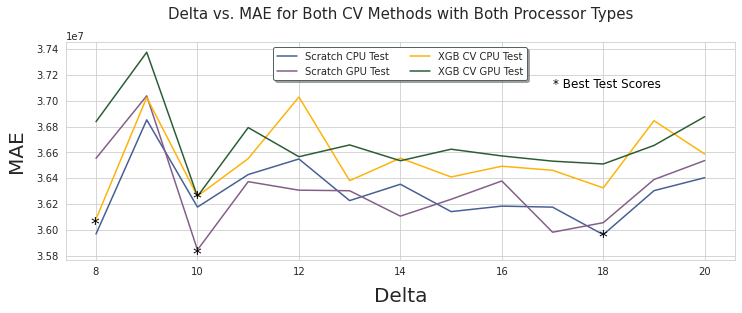

In [43]:
# plot cross validation results for deltas between 8 and 20 for both CV methods

sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))
sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.text(x=17.9, y=3.59e7, s='*', size='xx-large', color='k')
plt.text(x=9.9, y=3.577e7, s='*', size='xx-large', color='k')
plt.text(x=7.9, y=3.6e7, s='*', size='xx-large', color='k')
plt.text(x=9.9, y=3.62e7, s='*', size='xx-large', color='k')
plt.text(x=17, y=3.71e7, s='* Best Test Scores', size='large', color='k')

plt.xlabel('Delta', fontsize=20, labelpad=10)
plt.ylabel('MAE', fontsize=20, labelpad=10)

plt.legend(loc=9, ncol=2, shadow=True, fancybox=True, edgecolor=mp.colors(6))
plt.title('Delta vs. MAE for Both CV Methods with Both Processor Types', 
          fontsize=15, y=1.08);

These are the optimal delta values for the different CV methods.<br>
Scratch CPU: delta = 18<br>
Scratch GPU: delta = 10<br>
XGB CPU: delta = 8<br>
XGB GPU: delta = 10

Now, I'll show these results separately.

In [44]:
%%time
# get statistics for using CPU Scratch CV with delta = 18
{k: np.mean(v) for k, v in get_scratch_cv(X_train, y_train, 18, 'auto').items()}

CPU times: user 4min 25s, sys: 12.3 s, total: 4min 38s
Wall time: 11.8 s


{'test_mae': 35961850.4, 'train_mae': 20211092.7, 'n_boost': 259.8}

In [45]:
%%time
# get statistics for using GPU Scratch CV with delta = 10
{k: np.mean(v) for k, v in get_scratch_cv(X_train, y_train, 10, 'gpu_hist').items()}

CPU times: user 16.4 s, sys: 590 ms, total: 17 s
Wall time: 12.9 s


{'test_mae': 35843487.4, 'train_mae': 18699906.5, 'n_boost': 220.6}

In [46]:
%%time
# get statistics for using CPU XGB CV with delta = 8
{k: v for k, v in get_xgbr_cv(X_train, y_train, 8, 'auto').items()}

CPU times: user 6min 16s, sys: 17.1 s, total: 6min 33s
Wall time: 16.6 s


{'test_mae': 36082427.2, 'train_mae': 10589569.4, 'n_boost': 426}

In [47]:
%%time
# get statistics for using GPU XGB CV with delta = 10
{k: v for k, v in get_xgbr_cv(X_train, y_train, 10, 'gpu_hist').items()}

CPU times: user 13.3 s, sys: 538 ms, total: 13.8 s
Wall time: 9.76 s


{'test_mae': 36258228.2, 'train_mae': 22367009.6, 'n_boost': 143}

Seeing these results, I am choosing to use my GPU and the custom CV function with a delta value of 10.

The base model test CV MAE, using only the training data, was $41,215,414.04, obtained after the target optimization.<br>
The switch from using MAE to using the Pseudo-Huber to perform gradient descent has improved on this value, already.<br>
By making this change, the error has been reduced, again, by just over 13%.

I will perform an informed (Bayesian) search technique to find the best hyperparameters.<br>
This method has time advantages over a brute force grid search, which tries all combinations of hyperparameters.<br>
It is closer to a random grid search, except the choices of parameters are based on the results of previous choices.

 > **BAYESIAN HYPERPARAMETER SEARCH**

There are a lot of hyperparameters to tune.<br>
I will break them into three groups.<br>
 - Tree Structure Based Complexity Moderation (Bias/Variance Trade-off)
     - num_boost_round: Sets maximum number of boosting rounds 
         (limited by early_stopping_rounds)
         - Higher --> More Trees --> More Complixity
     - eta: Controls amount errors are corrected from previous round 
         - Lower --> Smaller Weights --> Less Complexity
     - max_depth: Controls how deep trees are allowed to grow 
         - Higher --> More Layers in Trees --> More Complexity
     - min_child_weight: Controls weight required to create new node 
         - Higher --> More Samples Needed To Split a Node --> Less Complexity
 - Stochastic Based Complexity Moderation (Used to Lower Variance)
     - subsample: Fraction of observations to use at each boosting round
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - colsample_bylevel: Fraction of features to use at each depth level
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - colsample_bynode: Fraction of features to use at each split
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - colsample_bytree: Fraction of features to use for each tree
         - Lower --> Sample is Less Representative of Data --> Less Complexity         
 - Regularization Based Complexity Moderation (Used to Lower Variance)
     - alpha: LASSO (L1) regularization
         - Higher --> Errors are more heavily penalized --> Less Complexity
     - lambda: Ridge (L2) regularization
         - Higher --> Errors are more heavily penalized --> Less Complexity
     - gamma: Lagrangian multiplier pseudo-regularization
         - Higher --> Greater loss reduction needed to make splits --> Less Complexity
     - max_delta_step: Absolute regularization
         - Higher --> Sets Cap on Leaf Score --> Less Complexity         

My strategy will be to march through the hyperparameters, adding them one by one to the search.<br>
I will be looking for the best range of the current hyperparameter to keep, before progressing to the next one.<br>
This will help to reduce the number of possible local minima that the model may fall into along the search.<br>
It will reduce search time, as well, as some parameters are additive in computation time, as their ranges expand.<br>
Hense, I will be applying appropriate upper limits to those values during the search.

As hyperparameters are added, the optimal ranges for previous ones may change.<br>
I will be monitoring these needs along the way, making appropriate adjustments when necessary.<br>
I will plot CV results over a range of hyperparameter values to monitor model performance within the search space.

I am using the results from the custom CV function to supply the metrics needed to perform the hyperparameter search.<br>
The function returns the results from 10 folds for both the test and training scores.<br>
The test loss will be the metric that is being optimized during the search for the best estimators for each batch of trials.

In [48]:
def objective(params, features, target, delta, 
              cv_type, processor_type, 
              max_boost_round, early_stopping_limit):
    """Returns CV results for XGB model"""
    # enable iteration marker to be GLOBAL variable
    global global_iterations
    # update marker
    global_iterations += 1
    # get all scores from 10 fold cross-validation
    cv_results = cv_type(features, target, delta, 
                         processor_type, params, 
                         max_boost_round=max_boost_round, 
                         early_stopping_limit=early_stopping_limit)
    # get average scores from 10 fold cross-validation
    average_test_mae = np.mean(cv_results['test_mae'])
    average_train_mae = np.mean(cv_results['train_mae'])
    # get average number of boosting rounds
    average_n_estimators = int(np.round(np.mean(cv_results['n_boost'])))

    return {
        'trial': global_trials, 
        'batch': global_batches, 
        'iteration': global_iterations, 
        'loss': average_test_mae, 
        'train_mae': average_train_mae, 
        'n_boost': average_n_estimators, 
        'params': params, 
        'status': STATUS_OK
    }

The optimization search will be callable for a maximum of 10 batches, with a default of 10 fits for each batch.<br>
The small batch size is needed, because of the large number of boosting rounds per model, as the search will be slow.<br>
Early stopping will be called if the loss function has not improved over a full batch from the best value of the previous batch.<br>
This is the early stopping of the informed search algorithm, not of the boosting of the individual models.

In [49]:
def run_trial_batches(features, target, delta, 
                      cv_type, processor_type, 
                      hp_space, trials, 
                      batch_size=10, max_batches=10, 
                      max_boost_round=500, early_stopping_limit=100):
    """Runs informed search trials in batches with a cap on the number of batches"""
    # enable trial marker to be GLOBAL variable (allows continuation of existing trial)
    global global_trials
    global_trials +=1
    # check for newly initialized trials object
    if not trials.losses():
        # initialize best loss and number of iterations for new trials object
        last_best = 0
        last_iters = 0
    else:
        # initialize best loss and number of iterations from imported trials object
        last_best = trials.best_trial['result']['loss']
        last_iters = len(trials.losses())
    # initialize best loss for batch
    new_best = 0
    # initialize early stop flag
    early_stop = 'GO!'
    # run optimization search over all batches
    for batch in range(max_batches):
        # check for early stop
        if early_stop == 'GO!':
            # enable batch marker to be GLOBAL variable
            global global_batches
            # update trials batch counter
            global_batches += 1
            # set iterations argument for maximum evaluations parameter of fmin function
            n_iters = batch_size * (batch + 1) + last_iters
            # use partial function to lower number of trials used to initialize warm start
            fmin_suggest = partial(tpe.suggest, n_startup_jobs=1)
            # use partial function to enable selection of trials data
            fmin_objective = partial(
                objective, features=features, target=target, delta=delta, 
                cv_type=cv_type, processor_type=processor_type, 
                max_boost_round=max_boost_round, early_stopping_limit=early_stopping_limit)
            # run one batch
            fmin(fn=fmin_objective, space=hp_space, max_evals=n_iters, trials=trials, 
                 algo=fmin_suggest, rstate=np.random.RandomState(27))
            # save updated results to M.2 (stores most recent trials object)
            pickle.dump(trials, open(
                '../data/xgbr_trials_optimized_target/xgbr_trials_last.pkl', 'wb'))
            # capture current optimal loss
            new_best = trials.best_trial['result']['loss']
            # check that batch optimized
            if last_best == new_best:
                early_stop = 'STOP!'
            last_best = new_best

 > **num_boost_round**

For XGBoost, the optimal number of boosting rounds is selected by the training algorithm, when using early stopping.<br>
Before training, the maximum number of rounds must be selected.<br>
Early stopping is called when the evaluation metric of consecutive models has not improved, over a selected iteration span.

When using XGBoost, these values are training parameters, not model hyperparameters.<br>
I can't pass them into the models by including them in the params argument, as I will do with the tuned hyperparameters.<br>
Still, I would like to optimize their selection, somehow.<br>
Fortunately, I can create a dummy key in the params argument, which is a dictionary, that will do the trick.<br>
The training algorithm will not pass any keys from the params dictionary to the models that they can't use.<br>
I can, then, assign the values, one by one, to a varable inside a custom grid function that calls the training algorithm.<br>
In this way, the params dictionary act like a Trojan horse, sneaking the arguments to the training algorithm.<br>
Finally, I can extract the values by calling the dummy key, and pass them as arguments to the training algorithm.<br>
Watch it happen.

In [50]:
def scratch_grid_cv(features, target, delta, cv_type, processor_type, grid, 
                    max_boost_round=500, early_stopping_limit=100):
    """Return search grid results from custom cross validation function"""
    # extract search target hyperparameter to display
    for key, value in grid.items():
        if len(value) > 1:
            searched_param = key
    # create list of all hyperparameter combinations
    keys = grid.keys()
    values = (grid[key] for key in keys)
    combos = [dict(zip(keys, combo)) for combo in product(*values)]
    # create empty list to hold MAE from each fold
    grid_dict = defaultdict(list)
    # perform grid search
    for params in combos:
        print(searched_param, ':', params[searched_param], '...')
        # check for hidden variables passed through param dict
        if 'max_boost_round' in params:
            max_boost_round = params['max_boost_round']
        if 'early_stopping_limit' in params:
            early_stopping_limit = params['early_stopping_limit']
        # collect 10 fold cv scores for hyperparameter combination
        scores_dict = cv_type(features, target, delta, processor_type, params, 
                              max_boost_round=max_boost_round, 
                              early_stopping_limit=early_stopping_limit)
        # get average scores and trees for hyperparameter combination over each CV fold
        grid_dict['params'].append(params)
        test_mean = np.mean(scores_dict['test_mae'])
        train_mean = np.mean(scores_dict['train_mae'])
        n_estimators_mean = np.mean(scores_dict['n_boost'])
        # update default dict with cv statistics for hyperparameter combination
        grid_dict['test_mean'].append(test_mean)
        grid_dict['n_estimators_mean'].append(n_estimators_mean)
        grid_dict['test_std'].append(np.std(scores_dict['test_mae']))
        
        print('Test MAE: {}\nTraining MAE: {}'.format(
            make_money(test_mean), make_money(train_mean)))
        print('Average Boosting Rounds: {}\n'.format(int(np.round(n_estimators_mean))))

    return grid_dict

In [51]:
def plot_hyperparameters(features, target, delta, cv_type, processor_type, grid):
    """Plots CV results over range of one hyperparameter"""
    # run 10 fold cv grid search and get error statistics to plot
    gs_df = pd.DataFrame(
        scratch_grid_cv(X_train, y_train, delta, cv_type, processor_type, grid))

    # plot errors over range for variable hyperparameter
    var_param = {k:v for (k, v) in grid.items() if len(v) > 1}
    for param, param_lst in var_param.items():
        # plot test scores
        sns.lineplot(x=param_lst, y=gs_df['test_mean'], label="Test Score", lw=2)
        plt.fill_between(param_lst, gs_df['test_mean'] - gs_df['test_std'],
                         gs_df['test_mean'] + gs_df['test_std'], alpha=0.2, lw=2)
        
        plt.xlabel(param, fontsize=15)  
        plt.ylabel("MAE", fontsize=15)

        plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')
        plt.title('Hyperparameters vs. Losses', fontsize=15)

I will begin by finding the best maximum number of boosting rounds to use.<br>
I will set the early stopping limit to the upper bound of my search space to ensure that it doesn't stop early.

In [52]:
# create parameter search grid
param_grid = {
    'early_stopping_limit': [500], 
    'max_boost_round': [int(x) for x in np.linspace(100, 500, num=5)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

early_stopping_limit [500]
max_boost_round [100, 200, 300, 400, 500]


max_boost_round : 100 ...
Test MAE: $36,361,769.80
Training MAE: $26,154,105.20
Average Boosting Rounds: 92

max_boost_round : 200 ...
Test MAE: $35,977,291.00
Training MAE: $21,881,680.00
Average Boosting Rounds: 152

max_boost_round : 300 ...
Test MAE: $35,897,531.00
Training MAE: $19,648,133.90
Average Boosting Rounds: 196

max_boost_round : 400 ...
Test MAE: $35,821,410.60
Training MAE: $17,657,224.20
Average Boosting Rounds: 248

max_boost_round : 500 ...
Test MAE: $35,775,250.20
Training MAE: $17,240,058.30
Average Boosting Rounds: 263

CPU times: user 59.4 s, sys: 478 ms, total: 59.9 s
Wall time: 60 s


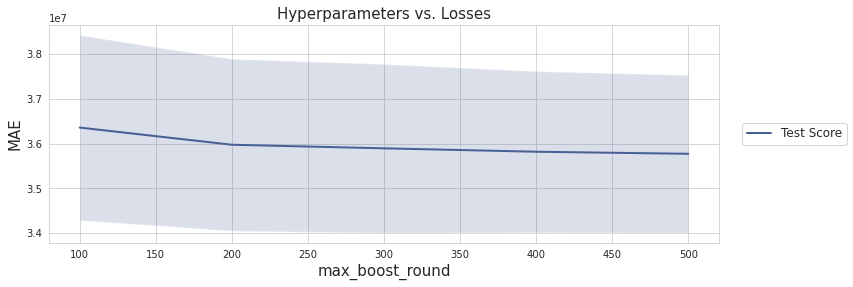

In [53]:
%%time
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

As is often the case, increasing boosting rounds increases model accuracy.<br>
A limit must be selected, though, because adding more rounds increases computational costs.<br>
I heuristically chose the maximum number of boosting rounds to be 500, at the start of this notebook.<br>
As stated earlier, this is a large number of rounds.<br>
My thinking was that I could decrease that limit, later, if I felt that I could get a good return on the computation time.<br>
As it stands now, I will not make that trade.<br>
I will keep the lower accuracy and monitor the computational cost along the way.

Now, I will observe the effects of using different values for the number of early stopping rounds.

 > **early_stopping_limit**

In [54]:
# create parameter search grid
param_grid = {
    'early_stopping_limit': [int(x) for x in np.linspace(80, 150, num=8)], 
    'max_boost_round': [500]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

early_stopping_limit [80, 90, 100, 110, 120, 130, 140, 150]
max_boost_round [500]


early_stopping_limit : 80 ...
Test MAE: $35,863,527.40
Training MAE: $20,244,350.90
Average Boosting Rounds: 194

early_stopping_limit : 90 ...
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Average Boosting Rounds: 221

early_stopping_limit : 100 ...
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Average Boosting Rounds: 221

early_stopping_limit : 110 ...
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Average Boosting Rounds: 221

early_stopping_limit : 120 ...
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Average Boosting Rounds: 221

early_stopping_limit : 130 ...
Test MAE: $35,810,179.80
Training MAE: $17,985,011.20
Average Boosting Rounds: 240

early_stopping_limit : 140 ...
Test MAE: $35,775,250.20
Training MAE: $17,240,058.30
Average Boosting Rounds: 263

early_stopping_limit : 150 ...
Test MAE: $35,775,250.20
Training MAE: $17,240,058.30
Average Boosting Rounds: 263

CPU times: user 1min 46s, sys: 767 ms, total: 1min 47s
Wall time: 1min 47s


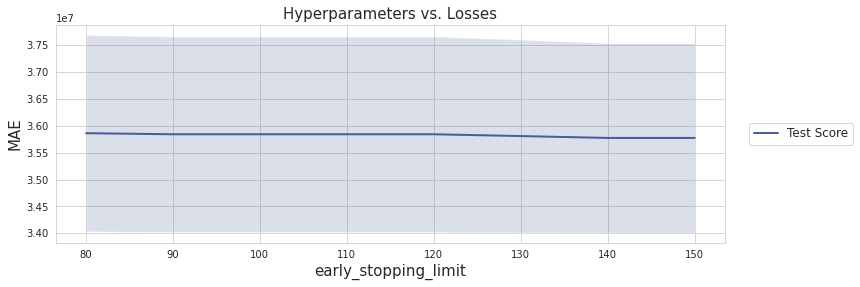

In [55]:
%%time
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

With the maximum boosting rounds set to 500, the best performance occurs at an early stopping value of 140 iterations.<br>
Compared to the original value of 100, the average number of boosting rounds increased by nearly 16%, from 221 to 263.<br>
As the maximum boosting rounds is set high, already, I'll keep the original value for this parameter, as well.

Before I start the hyperparameter search, I want to get a trials object for the base model for easy comparison.

 > **xgbr_trials_0**

In [56]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_0 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [57]:
# create informed search space using a single default value
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 6, 6.1))
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=10, cv_type=get_scratch_cv, 
                         processor_type='gpu_hist', max_boost_round=500, 
                         early_stopping_limit=100)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_0, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_0, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_0.pkl', 'wb'))

100%|██████████| 1/1 [00:12<00:00, 12.82s/trial, best loss: 35843487.4]


I will create a function to generate DataFrames to observe the best models for each trials object.

In [58]:
def make_trials_df(trials):
    """Makes a DataFrame from results dict of objective function sorted by loss"""
    # convert dict to DataFrame
    trials_df = pd.DataFrame(trials.results)
    # extract nested parameter dicts to separate DataFrame
    params_df = pd.DataFrame(trials_df['params'].to_list()).drop(
        ['disable_default_eval_metric', 'tree_method'], axis=1)
    # combine DataFrames, clean up, and order by best loss
    trials_df = trials_df.drop(
        ['params', 'status'], axis=1).join(
        params_df).sort_values('loss', ascending=True)
    
    return trials_df

In [59]:
# get results DataFrame
trials_0_df = make_trials_df(xgbr_trials_0)
trials_0_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,max_depth
0,0,0,1,35843487.4,18699906.5,221,6


In [60]:
def print_best_trial(trials):
    """Print test and training losses from selected trials object"""
    # get loss metrics
    test_mae = trials.best_trial['result']['loss']
    train_mae = trials.best_trial['result']['train_mae']
    n_boost = trials.best_trial['result']['n_boost']

    print('Test MAE: {}\nTraining MAE: {}\nNum Boosters: {}'.format(
        make_money(test_mae), make_money(train_mae), n_boost))

In [61]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


I'll confirm that this result is the same as the one obtained by using the custom CV function, without Hyperopt.

In [62]:
# observe average CV test MAE for delta=10
print_cv_mae(X_train, y_train, 10, get_scratch_cv, 'gpu_hist')

Delta: 10
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Boost Rounds: 221



To get some perspective on this loss, I'll show the broad range of average revenues for the actors' movies.

In [63]:
# get average movie revenue and revenue range for all actors in training data
print('Average Target Value: {}     Target Range: ({}, {})'.format(
    make_money(np.mean(np.exp(y_train))), 
    make_money(np.min(np.exp(y_train))), 
    make_money(np.max(np.exp(y_train)))))

Average Target Value: $81,851,821.32     Target Range: ($1.24, $999,601,802.16)


With this range so wide, it is important to observe the standard deviation of the data, as well.

In [64]:
# get standard deviation of movie revenue for all actors in training data
print('Standard Deviation of Target: {}'.format(make_money(np.std(np.exp(y_train)))))

Standard Deviation of Target: $120,817,369.06


Though the average error is large, it is well within one standard deviation of the target values.

Now, I will tune the hyperparameter eta, also called the learning rate.<br>
The split errors are multiplied by this value, globally, before the decision to split the nodes are made.<br>
This is a way to regularize errors that influence the decisions whether or not to split the nodes.<br>
A lower value will make the models more conservative.<br>
The default value is 0.3.

 > **eta**

In [65]:
# create parameter search grid
param_grid = {
    'eta': np.linspace(0.06, 0.22, 9)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22]


eta : 0.06 ...
Test MAE: $36,018,258.60
Training MAE: $26,144,379.20
Average Boosting Rounds: 484

eta : 0.08 ...
Test MAE: $35,754,930.60
Training MAE: $23,722,905.20
Average Boosting Rounds: 495

eta : 0.1 ...
Test MAE: $35,190,672.80
Training MAE: $22,065,118.00
Average Boosting Rounds: 449

eta : 0.12 ...
Test MAE: $35,161,257.40
Training MAE: $21,535,946.40
Average Boosting Rounds: 405

eta : 0.14 ...
Test MAE: $35,328,672.00
Training MAE: $21,075,046.40
Average Boosting Rounds: 365

eta : 0.16 ...
Test MAE: $35,438,444.60
Training MAE: $19,483,694.00
Average Boosting Rounds: 382

eta : 0.18 ...
Test MAE: $35,115,928.80
Training MAE: $17,755,400.10
Average Boosting Rounds: 392

eta : 0.2 ...
Test MAE: $35,490,208.40
Training MAE: $18,437,284.80
Average Boosting Rounds: 346

eta : 0.22 ...
Test MAE: $35,490,932.80
Training MAE: $17,786,449.30
Average Boosting Rounds: 317



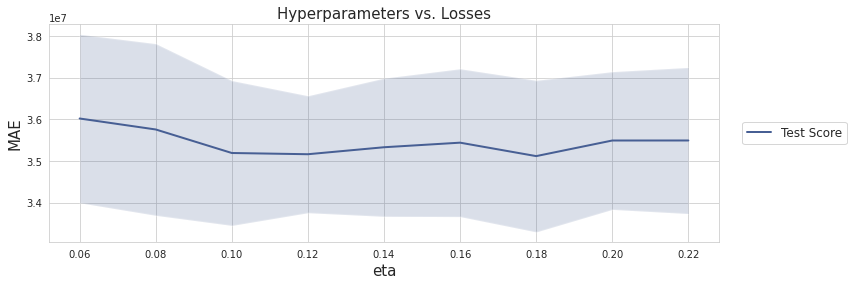

In [66]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

I'll compare this to the results from the base model.

In [67]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


There are 2 local minima over this range of values, at 0.1 and 0.18.<br>
I will set the learning rate range to be between 0.08 and 0.2 for the hyperparameter search space.

 > **xgbr_trials_1**

In [68]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_1 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [69]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.08, 0.2)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_1)
# save trials object
pickle.dump(xgbr_trials_1, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_1.pkl', 'wb'))

100%|██████████| 40/40 [03:06<00:00,  4.67s/trial, best loss: 34711206.2]


I will create a function to help monitor the hyperparameter selections made by the informed search algorithm.

In [70]:
def plot_param_search(trials):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (each hyperparameter + one optimization plot)
    num_subplots = len(trials.idxs.keys()) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot parameters of optimization run
    count = 1
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        
        # get number of trials in run
        n_iters = len(trials.losses())
        # get iteration of optimal objective loss
        best_iter = trials.best_trial['tid'] + 1        
        # get value for hyperparameter of best model
        best_val = trials.argmin[key]
        # get list of hyperparameter values
        vals_lst = trials.vals[key]
        
        # adjust values for data type
        if key in ['max_depth', 'min_child_weight']:
            best_val = int(best_val)
            vals_lst = list(map(int, vals_lst))
        else:
            best_val = round(best_val, 6)

        # plot hyperparameters for optimization run
        plt.plot(range(1, len(trials.results) + 1), vals_lst, 
                 marker='o', color=mp.colors(4), alpha=0.8)        
        # mark off optimal hyperparameter value
        plt.hlines(best_val, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
                   label='Optimal \n' + str(key) + ': \n' + '{:,}'.format(best_val), 
                   colors=mp.colors(2))
        # mark iteration of optimal objective loss at hyperparameter value
        plt.plot(best_iter, best_val, marker='*', ms=15, color=mp.colors(2))
        count += 1
        
        plt.ylabel(key, fontsize=18)
        
        plt.legend(bbox_to_anchor=(1.31, 0.5), loc=5, fontsize='x-large')

    plt.subplot(num_subplots, 1, count)
    
    # get optimal test loss value
    best_test_loss = trials.best_trial['result']['loss']
    
    # plot test loss for optimization run
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=trials.losses(), 
                 marker='o', label='Test Loss')
    
    # mark off best test loss
    plt.hlines(best_test_loss, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
               colors='k')
    # mark iteration of optimal test loss
    plt.plot(best_iter, best_test_loss, marker='*', ms=15, color='k', 
             label='Test Error: \n' + '${:,.2f}'.format(best_test_loss))

    plt.xlabel('Iteration (Best Iteration: ' + str(best_iter) + ')', fontsize=15)
    plt.ylabel('MAE', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1.33, 0.5), loc=5, fontsize='x-large', 
               title='Best Iteration', title_fontsize='x-large')
    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=23)

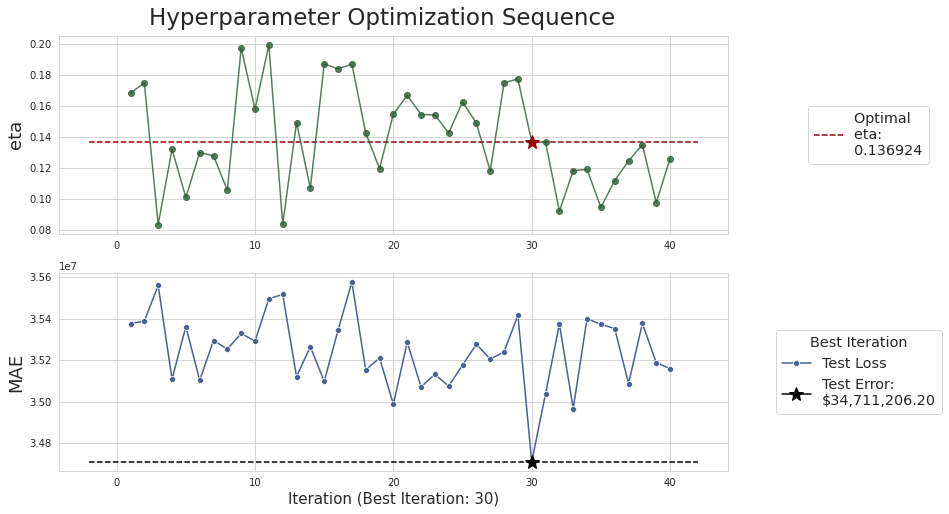

In [71]:
# plot informed search history
plot_param_search(xgbr_trials_1)

The informed search does not appear constrained by the range of allowable values for eta.

In [72]:
# get results DataFrame
trials_1_df = make_trials_df(xgbr_trials_1)
trials_1_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta
29,1,3,30,34711206.2,19149182.8,436,0.136924
32,1,4,33,34967768.0,21273690.0,420,0.118080
19,1,2,20,34988719.0,18381281.3,425,0.154680
30,1,4,31,35038632.0,18847987.0,450,0.136421
21,1,3,22,35072353.2,19953966.0,371,0.154406
23,1,3,24,35075230.6,20480780.0,382,0.142456
36,1,4,37,35087966.0,19892671.4,453,0.124418
14,1,2,15,35098556.8,17639418.4,376,0.187195
5,1,1,6,35103824.6,20189872.2,412,0.129835
3,1,1,4,35109786.0,19765366.4,429,0.131951


I'll show the base model scores to see the improvements.

In [73]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


The top model has an improved test loss by well over a million dollars.

As expected, lowering the learning rate has produced less complex models, leading to improved generalizability.

I will look at the distribution of values chosen for the hyperparameter during the search.

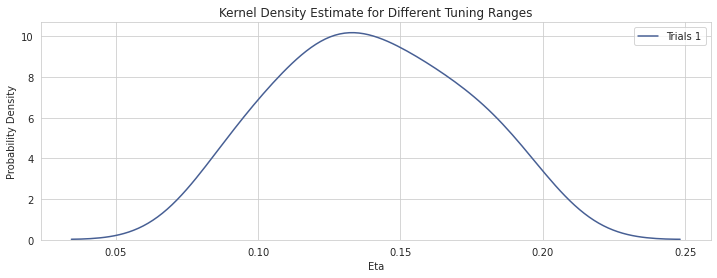

In [74]:
# plot kernel density estimates for learning rate

sns.kdeplot(trials_1_df['eta'], label='Trials 1')

plt.xlabel('Eta')
plt.ylabel('Probability Density')

plt.title('Kernel Density Estimate for Different Tuning Ranges');

The chosen range is supporting a balanced distribution of hyperparameters.

I will observe the losses over the range of hyperparameters to notice the effects of different choices.

In [75]:
def plot_one_param(trials, param, param_min=None, param_max=None):
    """Plots MAEs vs. one hyperparameter with the option to limit the range"""
    df = make_trials_df(trials)
    # check to see if range needs to be altered
    if (param_min and param_max):
        df = df[(df[param] > param_min) & (df[param] < param_max)]        
    # plot hyperparameters for optimization run
    sns.regplot(x=param, y='loss', data=df, 
        scatter_kws={"s": 10}, label='Test Loss')

    plt.xlabel(param, fontsize=14)
    plt.ylabel('MAE', fontsize=14)
    
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')

In [76]:
def plot_maes(trials):
    """Plots mean absolute errors for all hyperparameters"""
    # establish figure height
    num_subplots = len(trials.idxs)
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot hyperparameters of optimization run
    count = 1
    # get all hyperparameters in trials object
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        # call hyperparameter plotting function
        plot_one_param(trials, key)
        
        plt.xlabel(key, fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        
        plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')
        count += 1
        
    plt.suptitle('Hyperparameter Informed Search Results', 
                 y=1 - (num_subplots / 50), fontsize=23);

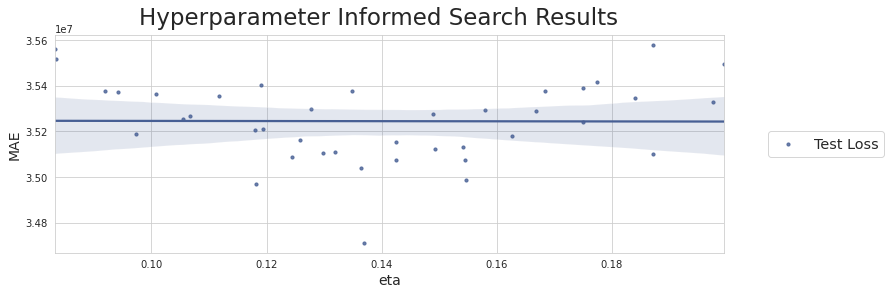

In [77]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_1)

The average test loss is constant throughout this range.<br>
This indicates that this is a good range of eta to continue the search using more hyperparameters.

I will keep this search space for now.

Now, I will continue the search by tuning the depth the trees are allowed to be grown.<br>
Increasing the trees depth increases complexity and computation time.<br>
The default value is of 6.

 > **max_depth**

In [78]:
# get best hyperparameters from last trials
best_params = xgbr_trials_1.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [int(x) for x in np.linspace(8, 22, num=8)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.13692436117600948]
max_depth [8, 10, 12, 14, 16, 18, 20, 22]


max_depth : 8 ...
Test MAE: $34,046,147.60
Training MAE: $11,841,271.90
Average Boosting Rounds: 405

max_depth : 10 ...
Test MAE: $33,597,868.60
Training MAE: $6,271,324.15
Average Boosting Rounds: 402

max_depth : 12 ...
Test MAE: $33,469,537.20
Training MAE: $3,585,933.23
Average Boosting Rounds: 378

max_depth : 14 ...
Test MAE: $33,326,664.00
Training MAE: $2,832,468.88
Average Boosting Rounds: 355

max_depth : 16 ...
Test MAE: $33,386,582.60
Training MAE: $810,362.43
Average Boosting Rounds: 379

max_depth : 18 ...
Test MAE: $32,991,632.80
Training MAE: $1,070,606.58
Average Boosting Rounds: 333

max_depth : 20 ...
Test MAE: $33,304,822.00
Training MAE: $1,067,281.29
Average Boosting Rounds: 315

max_depth : 22 ...
Test MAE: $33,158,183.80
Training MAE: $744,894.67
Average Boosting Rounds: 288



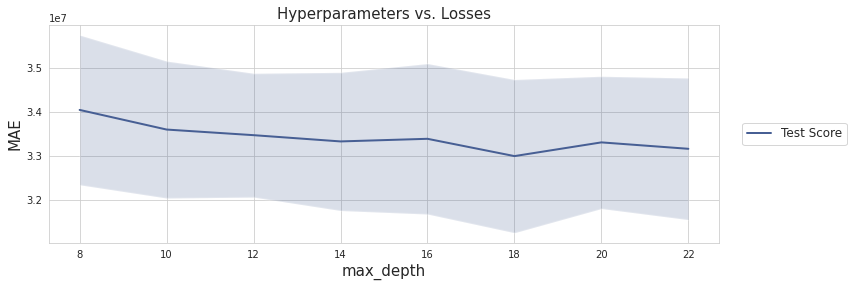

In [79]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

Now, I will compare these results with the best model from the last search round.

In [80]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Test MAE: $34,711,206.20
Training MAE: $19,149,182.80
Num Boosters: 436


The best choice for maximum tree depth is a value of 18.<br>
Choosing this depth will be computationally expensive.<br>
It is very deep for boosted trees to be grown for an ensemble, as well.<br>
Despite this, I am willing to press ahead with this high range, as I feel this is where the search is leading me.<br>
Though the optimal range is between 16 and 20, I want the lower bound to be wider to search for models with less depth.<br>
Therefore, I will set the range to be between 10 and 20.

 > **xgbr_trials_2**

In [81]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_2 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

Note, for max depth, I am having Hyperopt choose from a range of float values that are then converted to integers.<br>
I am doing this, because of the way my plotting functions use the trials objects to display the results.<br>
Using the Hyperopt choice function, which is standard, leads to plot values that are one integer too small.<br>
Therefore, when I desire an upper limit for an integer valued hyperparameter, I will set the range to be one integer greater.<br>
Once the float value is converted to an integer, it will be lowered back to the value that I want<br>
Thus below, you will see that I am telling Hyperopt to search between 10 and 21.<br>
This will result in the search being between 10 and 20, as stated above, while keeping my plotting functions cleaner.

In [82]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.08, 0.2), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_2)
# save trials object
pickle.dump(xgbr_trials_2, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_2.pkl', 'wb'))

100%|██████████| 20/20 [17:56<00:00, 53.80s/trial, best loss: 32994569.0] 


As expected, the computational time has increased at least 5 fold.

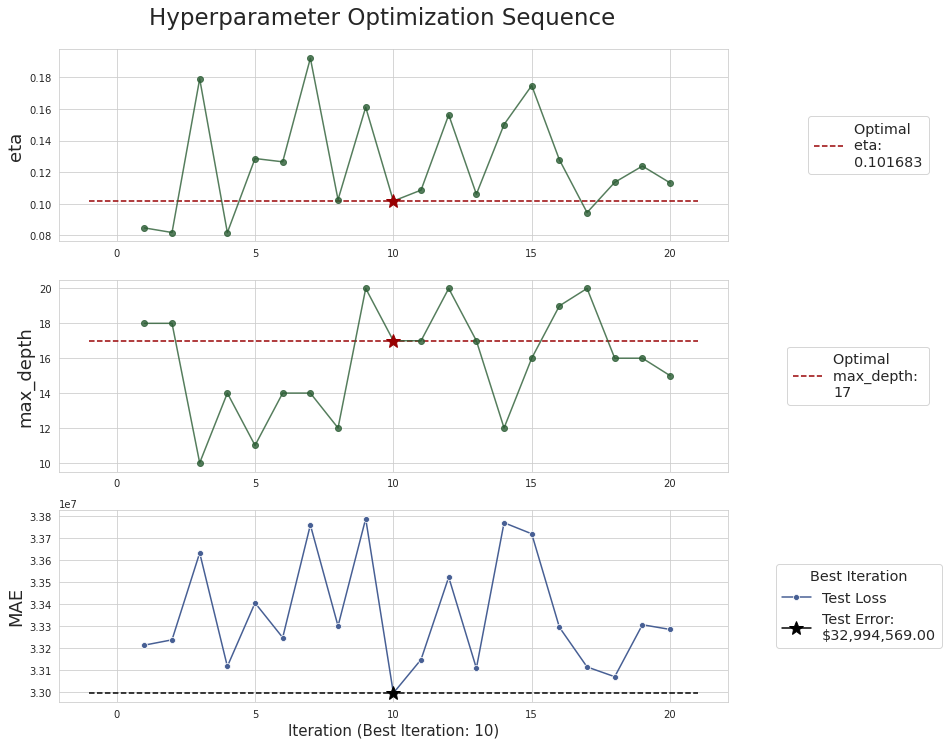

In [83]:
# plot informed search history
plot_param_search(xgbr_trials_2)

In [84]:
# get results DataFrame
trials_2_df = make_trials_df(xgbr_trials_2)
trials_2_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth
9,1,1,10,32994569.0,1.440253e+06,402,0.101683,17
17,1,2,18,33068892.8,2.034877e+06,359,0.113538,16
12,1,2,13,33107276.8,1.129082e+06,404,0.106026,17
16,1,2,17,33113208.6,1.226335e+06,400,0.094390,20
3,1,1,4,33115579.2,3.378283e+06,464,0.081680,14
10,1,2,11,33146770.6,1.634443e+06,390,0.108600,17
0,1,1,1,33212102.4,1.467943e+06,464,0.084676,18
1,1,1,2,33236252.6,1.345051e+06,452,0.081751,18
5,1,1,6,33246489.0,1.335992e+06,424,0.126524,14
19,1,2,20,33283408.2,1.405005e+06,415,0.113195,15


The test loss has been reduced by almost another 2 million dollars.

In [85]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Test MAE: $34,711,206.20
Training MAE: $19,149,182.80
Num Boosters: 436


I will create a function to plot the distribution of the hyperparameter choices made during the different informed searches.

In [86]:
def plot_kde(trials_dict):
    """Plot range of hyperparameters for each trial given"""
    # create empty dict to hold DataFrames of trials parameters
    df_dict = {}
    # fill dict with each DataFrame
    for trial, num in trials_dict.items():
        # create default dict to sort values of hyperparameters
        param_dict = defaultdict(list)
        # extract iterations
        for d in trial.miscs:
            # sort values from iteration
            for key, val in d['vals'].items():
                param_dict[key].append(val[0])
            # store sorted hyperparameter values from each trial in DataFrame
            param_df = pd.DataFrame(param_dict)
        # add DataFrame to dict
        df_dict[num] = param_df
    # get maximum number of hyperparameters to establish subplots
    n_rows = max([len(x.columns) for x in df_dict.values()])
    fig_height = n_rows * 4
    fig, axes = plt.subplots(nrows=n_rows, figsize=(12, fig_height))
    # create empty dict to map hyperparameters to axes numbers
    axes_dict = {}
    ax_num = -1
    # expand my color palette by looping it three times
    my_palette = ['xkcd:' + c for c in mp.my_colors] * 3
    # sort hyperparameters out of DataFrames
    for num, df in df_dict.items():
        # get list of hyperparameters from DataFrame
        cols_lst = list(df.columns)
        # go through hyperparameters and plot
        for param in cols_lst:
            # build axes mapper
            if param not in list(axes_dict.keys()):
                ax_num += 1
                axes_dict[param] = ax_num
            # plot kernel density estimate for hyperparameter
            g = sns.kdeplot(df[param], label=num, color=my_palette[num - 1], 
                        ax=axes[axes_dict[param]])
            g.set_xlabel(param, fontsize=15)
            g.set_ylabel('Probability Density', fontsize=15)

    plt.suptitle('Kernel Density Estimates for Different Tuning Ranges', fontsize=15)
    plt.subplots_adjust(top=0.95)

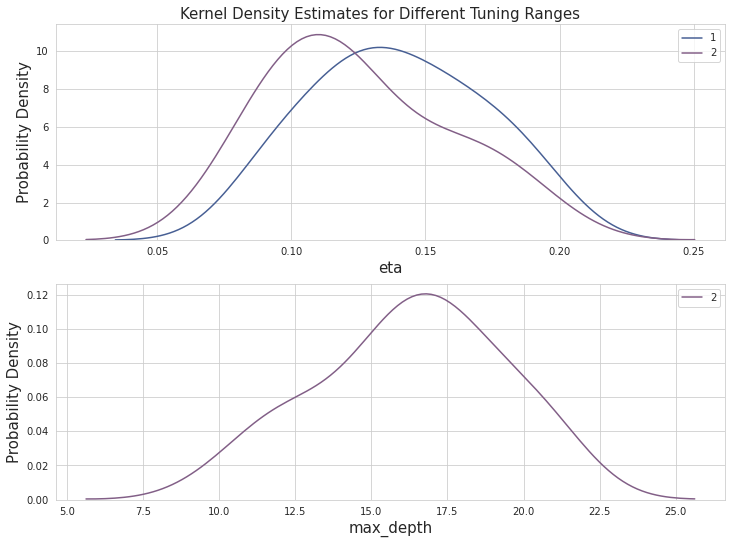

In [87]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2
        }
# plot the results, so far
plot_kde(_dict)

With the expansion of the tree depth the models are choosing lower eta values.<br>
This is helping to reduce the model complexity that is being created by the deeper trees.

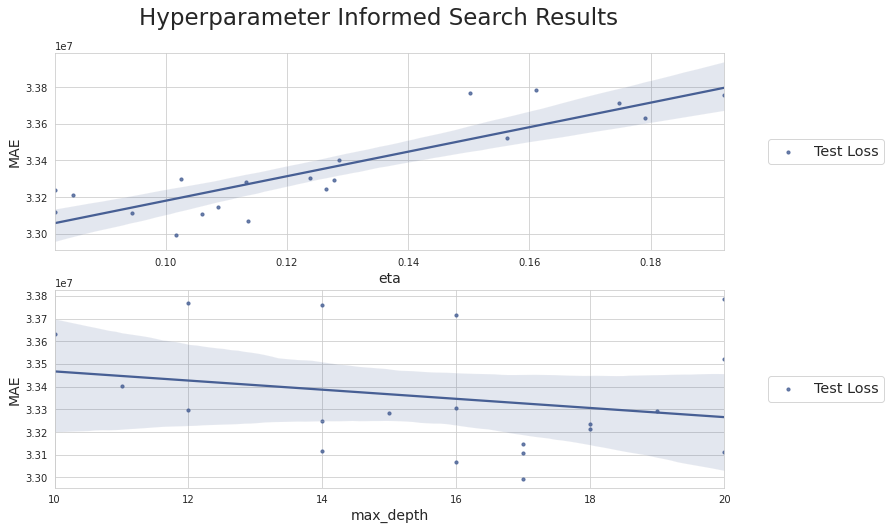

In [88]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_2)

The search is getting better results by using models with more depth and lower learning rates.<br>
The severe slope of the eta plot makes me want to lower the entire range to search for models with less complexity.<br>
I will observe the results of shifting the range of eta values to be between 0.03 and 0.12.

 > **eta (retune)**

In [89]:
# get best hyperparameters from last trials
best_params = xgbr_trials_2.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': np.linspace(0.03, 0.12, 10), 
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12]
max_depth [17]


eta : 0.03 ...
Test MAE: $33,674,555.00
Training MAE: $11,518,028.00
Average Boosting Rounds: 498

eta : 0.04 ...
Test MAE: $33,273,829.00
Training MAE: $7,462,812.00
Average Boosting Rounds: 496

eta : 0.05 ...
Test MAE: $32,801,293.80
Training MAE: $4,830,551.20
Average Boosting Rounds: 497

eta : 0.06 ...
Test MAE: $32,805,609.80
Training MAE: $2,969,168.33
Average Boosting Rounds: 497

eta : 0.07 ...
Test MAE: $33,226,133.00
Training MAE: $2,075,417.20
Average Boosting Rounds: 483

eta : 0.08 ...
Test MAE: $33,101,044.80
Training MAE: $1,510,046.16
Average Boosting Rounds: 473

eta : 0.09 ...
Test MAE: $32,938,059.40
Training MAE: $1,593,968.32
Average Boosting Rounds: 436

eta : 0.1 ...
Test MAE: $33,035,787.60
Training MAE: $1,673,962.61
Average Boosting Rounds: 413

eta : 0.11 ...
Test MAE: $33,284,730.00
Training MAE: $1,180,362.39
Average Boosting Rounds: 410

eta : 0.12 ...
Test MAE: $33,353,569.20
Training MAE: $1,232,599.62
Average Boosting Rounds: 393



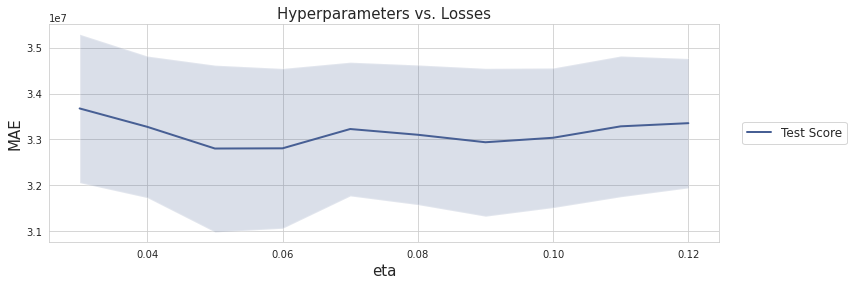

In [90]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [91]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_2)

Test MAE: $32,994,569.00
Training MAE: $1,440,253.36
Num Boosters: 402


There is a large valley between eta values of 0.04 and 0.07, where the test score drops below that of the last best model.<br>
Although there is another good score at an eta value of 0.09, it is not as low.<br>
I will shift the search to that lower range.

 > **xgbr_trials_3**

In [92]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [93]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3)
# save trials object
pickle.dump(xgbr_trials_3, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3.pkl', 'wb'))

100%|██████████| 40/40 [18:42<00:00, 28.05s/trial, best loss: 32492178.2] 


Training times are holding steady.

Because the early stopping was deactivated during the second and third batches, the entire run performed 40 trials.<br>
This allowed the chosen range of hyperparameters to have a better chance of finding the next best model.<br>
I will allow the subsequent runs to perform that many trials, as well, until a new best model is found.

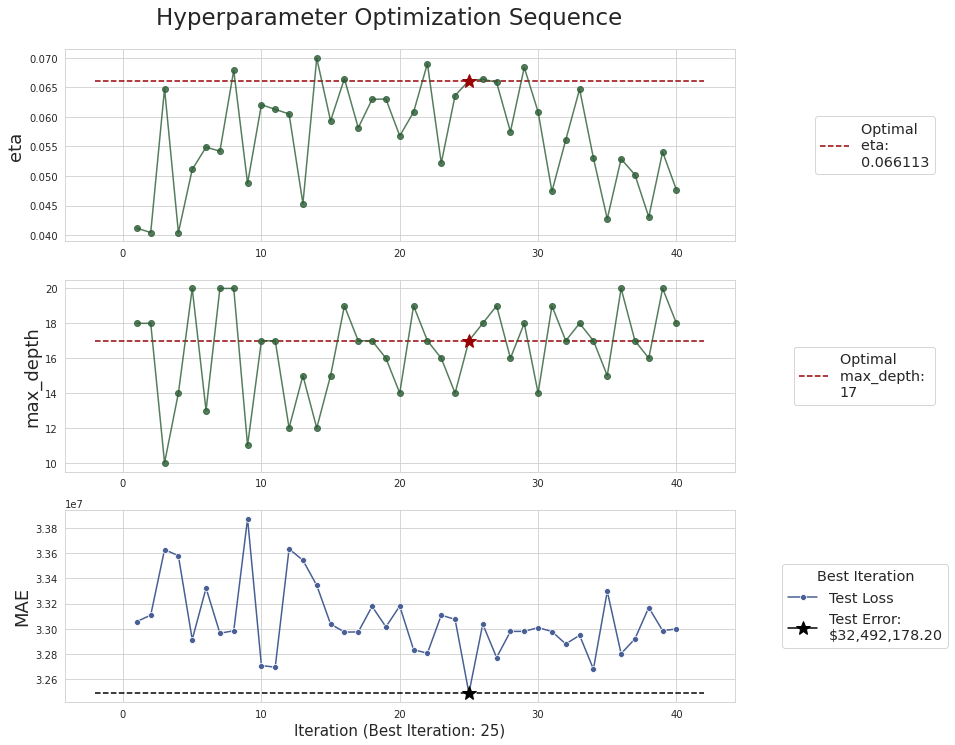

In [94]:
# plot informed search history
plot_param_search(xgbr_trials_3)

In [95]:
# get results DataFrame
trials_3_df = make_trials_df(xgbr_trials_3)
trials_3_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth
24,1,3,25,32492178.2,2.291293e+06,487,0.066113,17
33,1,4,34,32681845.2,4.458859e+06,494,0.053009,17
10,1,2,11,32697065.2,2.901829e+06,492,0.061255,17
9,1,1,10,32709703.2,3.106126e+06,478,0.062042,17
26,1,3,27,32773216.4,1.791878e+06,479,0.065836,19
35,1,4,36,32804117.2,2.692844e+06,497,0.052877,20
21,1,3,22,32807299.6,2.314445e+06,473,0.068996,17
20,1,3,21,32835007.2,2.257840e+06,483,0.060799,19
31,1,4,32,32880425.4,3.788152e+06,493,0.056101,17
4,1,1,5,32915446.2,3.255543e+06,482,0.051099,20


The test loss has decreased by another half a million dollars.<br>
The top models are using a depth of 17 to make their trees.<br>
This leads me to believe that the search is making good use of the high range of tree depth.

In [96]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_2)

Test MAE: $32,994,569.00
Training MAE: $1,440,253.36
Num Boosters: 402


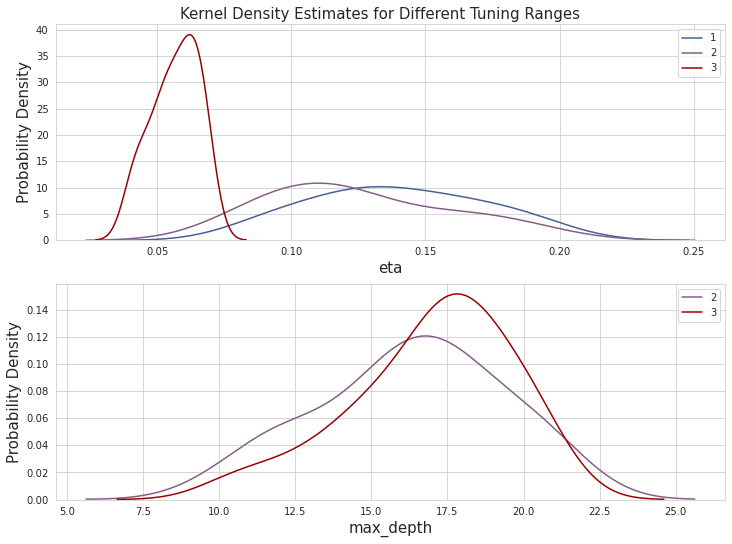

In [97]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3
        }
# plot the results, so far
plot_kde(_dict)

Comparing the eta distributions of this trials object and the others is uninformative, as the search ranges are not the same.<br>
Although, that shift has allowed the tree depth search to wade into higher values.

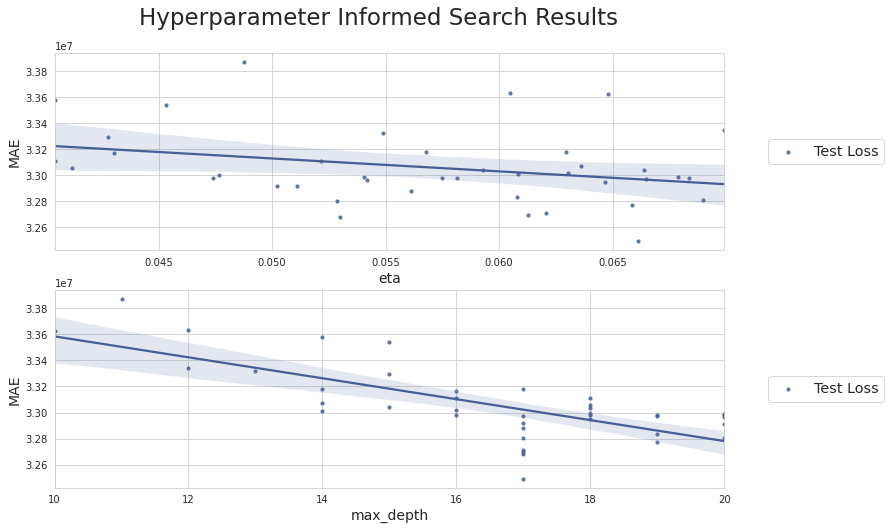

In [98]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_3)

The search algorithm favors a the higher values of tree depth.<br>
The current range is the highest that I am willing to try, as the computation times have gotten long.

Next, I will tune the weight required to create new nodes.<br>
For regression tasks, this is the same as the number of samples in the node needed, before it can be split.<br>
Increasing this value reduces model complexity.<br>
The default value is 1.

 > **min_child_weight**

In [99]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'min_child_weight': [int(x) for x in np.linspace(1, 3, num=3)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06611282032366718]
max_depth [17]
min_child_weight [1, 2, 3]


min_child_weight : 1 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487

min_child_weight : 2 ...
Test MAE: $33,476,972.60
Training MAE: $8,243,899.40
Average Boosting Rounds: 464

min_child_weight : 3 ...
Test MAE: $34,043,464.60
Training MAE: $12,923,106.10
Average Boosting Rounds: 449



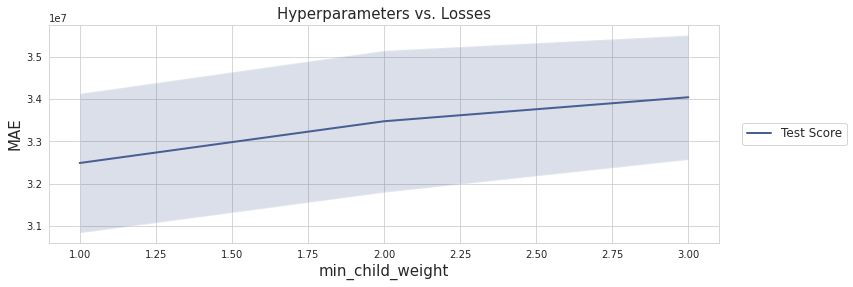

In [100]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [101]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The default value gives the best results.<br>
I will confirm this with a search, using values of either 1 or 2.

Spoiler Alert!<br>
For ease of final analysis, I have labeled the trials that don't produce a better model with letter subscripts.

> **xgbr_trials_3a**

In [102]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [103]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21)), 
    'min_child_weight': ho_scope.int(hp.uniform('min_child_weight', 1, 3))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3a)
# save trials object
pickle.dump(xgbr_trials_3a, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3a.pkl', 'wb'))

100%|██████████| 30/30 [18:16<00:00, 36.56s/trial, best loss: 32677886.4] 


I will allow a second trial run to ensure that there are at least 40 trials total.

In [104]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3a)
# save trials object
pickle.dump(xgbr_trials_3a, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3a.pkl', 'wb'))

100%|██████████| 40/40 [16:18<00:00, 24.45s/trial, best loss: 32677886.4] 


In [105]:
# get results DataFrame
trials_3a_df = make_trials_df(xgbr_trials_3a)
trials_3a_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth,min_child_weight
12,1,2,13,32677886.4,2.734659e+06,473,0.063453,18,1
27,1,3,28,32735096.8,2.987657e+06,469,0.060822,18,1
4,1,1,5,32807171.6,3.865721e+06,479,0.048665,20,1
23,1,3,24,32833302.4,1.776556e+06,494,0.061028,20,1
2,1,1,3,32843513.2,3.794085e+06,499,0.048731,19,1
17,1,2,18,32871417.0,4.505399e+06,489,0.047154,19,1
13,1,2,14,32880960.6,2.674169e+06,480,0.065276,17,1
38,2,4,39,32900588.2,2.509634e+06,487,0.061813,18,1
20,1,3,21,32901218.8,1.478923e+06,476,0.067539,20,1
18,1,2,19,32907453.8,3.264480e+06,481,0.053840,19,1


As expected from the results of the grid search, the default value of 1 is optimal.

In [106]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


There is a relationship between tree depth and node weights.<br>
When a tree is grown, child creation is performed greedily.<br>
The nodes want to be split, giving a tendency toward model complexity.<br>
If trees are allowed to add many layers, the samples in each node become fewer.<br>
Because of this node sample sparcity, raising the critical weight that allows nodes to be split, will produce shorter trees.<br>
This will remove the performance gains obtained through growing deep trees.<br>
It is not surprising that increasing the sample size needed to split nodes leads to a decrease in model performance.

I will move on to the stochastic hyperparameters.<br>
They all have default values of 1.

The first sampling method I will adjust is the percent of observations to use at each round.<br>
I will show the results where the models used between 90 and 100% of the available observations.

 > **subsample**

In [107]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': np.linspace(0.9, 1, 6)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06611282032366718]
max_depth [17]
subsample [0.9  0.92 0.94 0.96 0.98 1.  ]


subsample : 0.9 ...
Test MAE: $32,847,200.80
Training MAE: $2,244,341.09
Average Boosting Rounds: 477

subsample : 0.92 ...
Test MAE: $32,863,221.60
Training MAE: $2,420,828.55
Average Boosting Rounds: 470

subsample : 0.9400000000000001 ...
Test MAE: $32,768,482.20
Training MAE: $2,028,381.89
Average Boosting Rounds: 491

subsample : 0.96 ...
Test MAE: $32,826,181.60
Training MAE: $2,024,730.04
Average Boosting Rounds: 495

subsample : 0.98 ...
Test MAE: $32,806,737.80
Training MAE: $2,929,397.64
Average Boosting Rounds: 456

subsample : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



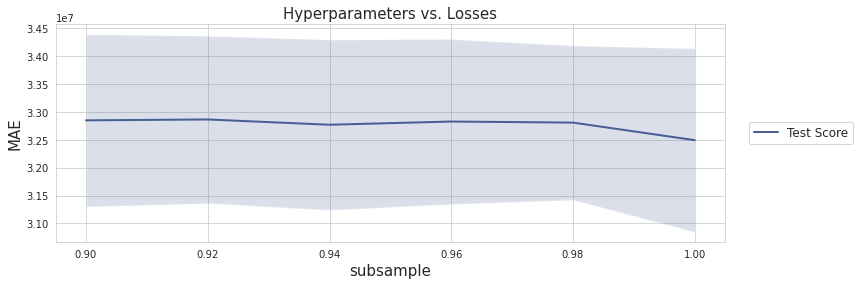

In [108]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [109]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The models perform better using all of the samples.<br>
I will show this below.

 > **xgbr_trials_3b**

In [110]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [111]:
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 20)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3b)
# save trials object
pickle.dump(xgbr_trials_3b, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3b.pkl', 'wb'))

100%|██████████| 20/20 [14:27<00:00, 43.38s/trial, best loss: 32705287.4]


In [112]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3b)
# save trials object
pickle.dump(xgbr_trials_3b, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3b.pkl', 'wb'))

100%|██████████| 50/50 [16:48<00:00, 20.17s/trial, best loss: 32581555.8] 


In [113]:
# get results DataFrame
trials_3b_df = make_trials_df(xgbr_trials_3b)
trials_3b_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth,subsample
36,2,4,37,32581555.8,4508476.950,496,0.050366,17,0.981864
44,2,5,45,32610212.8,3235319.975,480,0.052852,19,0.985025
32,2,4,33,32650774.0,4545400.025,496,0.045950,18,0.967397
47,2,5,48,32655689.4,5060625.200,493,0.050963,16,0.982531
21,2,3,22,32677634.4,1454584.575,487,0.067502,19,0.942860
6,1,1,7,32705287.4,3993133.425,492,0.058356,15,0.935556
38,2,4,39,32707206.6,3729130.500,496,0.050076,18,0.974392
33,2,4,34,32721772.0,4598146.325,496,0.045665,18,0.970972
14,1,2,15,32722012.2,2929455.000,477,0.059829,17,0.943071
37,2,4,38,32726165.4,5101648.950,498,0.047075,17,0.981273


In [114]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


Even after 50 trials, the search did not find a better model than what was found using all of the observations.<br>
I will keep the default value for this hyperparameter.

I will move on to sampling by features, as opposed to sampling by observations.<br>
The first way I will allow the models to subset features is by picking different ones at each depth of the tree.

I will show the grid search results for the range between 50 and 100% of the features.

 > **colsample_bylevel**

In [115]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bylevel': np.linspace(0.5, 1.0, 6), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bylevel [0.5 0.6 0.7 0.8 0.9 1. ]
eta [0.06611282032366718]
max_depth [17]


colsample_bylevel : 0.5 ...
Test MAE: $32,926,829.80
Training MAE: $4,120,853.02
Average Boosting Rounds: 469

colsample_bylevel : 0.6 ...
Test MAE: $32,995,499.00
Training MAE: $3,614,582.83
Average Boosting Rounds: 468

colsample_bylevel : 0.7 ...
Test MAE: $32,682,870.60
Training MAE: $2,937,617.98
Average Boosting Rounds: 487

colsample_bylevel : 0.8 ...
Test MAE: $32,629,489.60
Training MAE: $3,193,584.98
Average Boosting Rounds: 476

colsample_bylevel : 0.9 ...
Test MAE: $33,040,303.60
Training MAE: $2,466,744.33
Average Boosting Rounds: 491

colsample_bylevel : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



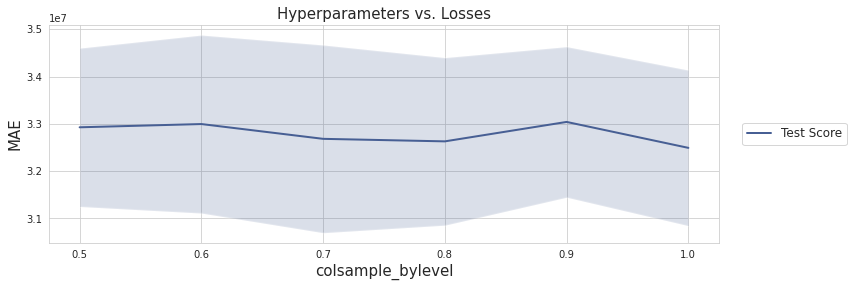

In [116]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [117]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


Although there is a local vallley between 70 and 80%, the models perform best selecting from all of the features.<br>
This is shown below.

 > **xgbr_trials_3c**

In [118]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [119]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3c)
# save trials object
pickle.dump(xgbr_trials_3c, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3c.pkl', 'wb'))

100%|██████████| 30/30 [15:38<00:00, 31.29s/trial, best loss: 32541859.0] 


In [120]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3c)
# save trials object
pickle.dump(xgbr_trials_3c, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_3c.pkl', 'wb'))

100%|██████████| 40/40 [17:28<00:00, 26.21s/trial, best loss: 32541859.0] 


In [121]:
# get results DataFrame
trials_3c_df = make_trials_df(xgbr_trials_3c)
trials_3c_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bylevel,eta,max_depth
13,1,2,14,32541859.0,2.211888e+06,487,0.779573,0.062083,20
17,1,2,18,32554036.2,3.213223e+06,467,0.638998,0.059168,20
10,1,2,11,32568715.0,2.748698e+06,492,0.662571,0.058690,20
31,2,4,32,32594993.4,3.397067e+06,476,0.744742,0.061246,18
33,2,4,34,32607630.6,2.793125e+06,489,0.702897,0.057622,20
24,1,3,25,32617266.2,2.635125e+06,498,0.763830,0.066110,17
32,2,4,33,32673776.4,1.562384e+06,490,0.965787,0.064764,20
29,1,3,30,32720717.4,5.554178e+06,496,0.798925,0.049680,17
7,1,1,8,32722538.0,5.320759e+06,498,0.933147,0.046052,18
18,1,2,19,32754205.6,3.277854e+06,495,0.738139,0.056048,19


With that adjustment, the learning rate is not struggling to find useful values as much.

In [122]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The models performed best when the tree depth was raised to its allowable upper limit.<br>
While there may be performance gains with deeper trees, I can see that the run times of the trials has noticeably increased.<br>
I will not explore this deeper search space and am keeping the hyperparameter at its default value.

The next way I will allow the models to use a subsampling of the features is at each node split evaluation.<br>
I will show the results of sampling between 70 and 100% of the features.

 > **colsample_bynode**

In [123]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': np.linspace(0.7, 1.0, 4), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.7 0.8 0.9 1. ]
eta [0.06611282032366718]
max_depth [17]


colsample_bynode : 0.7 ...
Test MAE: $33,040,961.40
Training MAE: $3,138,231.65
Average Boosting Rounds: 475

colsample_bynode : 0.7999999999999999 ...
Test MAE: $32,784,778.60
Training MAE: $2,816,401.80
Average Boosting Rounds: 483

colsample_bynode : 0.9 ...
Test MAE: $32,675,666.20
Training MAE: $2,780,135.35
Average Boosting Rounds: 481

colsample_bynode : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



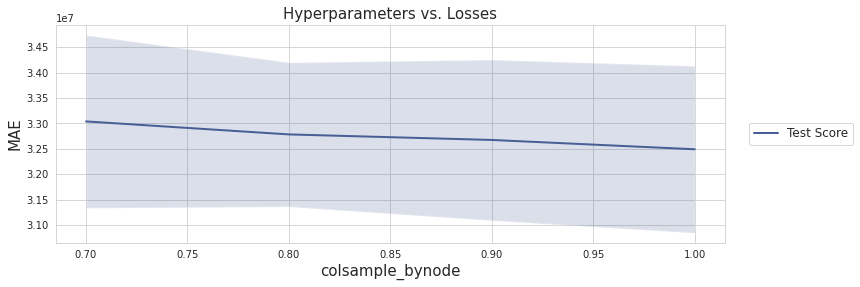

In [124]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [125]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The model performance steadily decreases as the percentage of samples increases.<br>
I will make the lower bound of the search to be set at 80%.

 > **xgbr_trials_4**

In [126]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [127]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4)
# save trials object
pickle.dump(xgbr_trials_4, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_4.pkl', 'wb'))

100%|██████████| 20/20 [24:40<00:00, 74.00s/trial, best loss: 32483288.4] 


The computation cost has increased, again.<br>
The trial times are reaching the limit of what I want to allow.

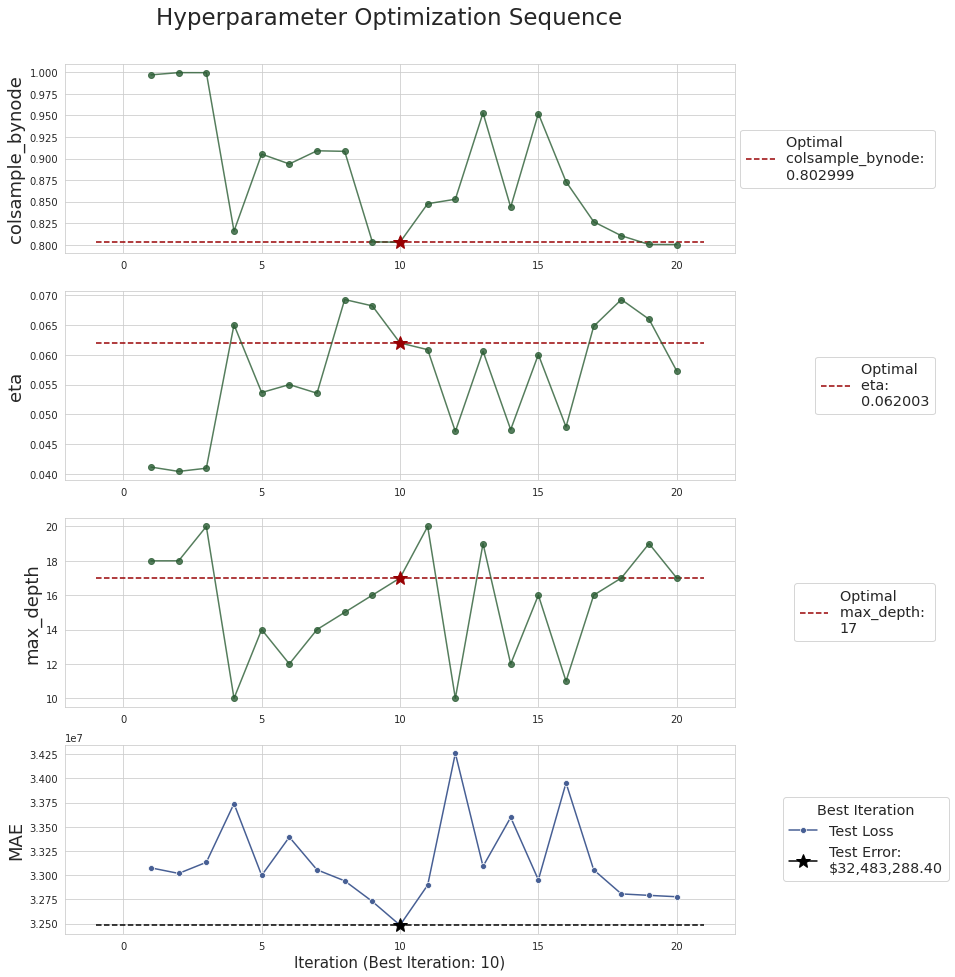

In [128]:
# plot informed search history
plot_param_search(xgbr_trials_4)

In [129]:
# get results DataFrame
trials_4_df = make_trials_df(xgbr_trials_4)
trials_4_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_depth
9,1,1,10,32483288.4,3.315337e+06,482,0.802999,0.062003,17
8,1,1,9,32728606.4,3.055882e+06,484,0.803391,0.068222,16
19,1,2,20,32777325.6,3.832676e+06,494,0.800319,0.057305,17
18,1,2,19,32791564.8,2.048678e+06,478,0.800377,0.065981,19
17,1,2,18,32806579.6,2.465624e+06,482,0.810495,0.069287,17
10,1,2,11,32897968.8,2.320908e+06,476,0.847666,0.060874,20
7,1,1,8,32941667.8,3.836856e+06,469,0.908412,0.069289,15
14,1,2,15,32952102.2,4.077703e+06,483,0.952245,0.060053,16
4,1,1,5,32997889.2,7.487623e+06,494,0.905189,0.053677,14
1,1,1,2,33018312.8,6.577335e+06,495,0.999713,0.040438,18


In [130]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The best models subsampled about 80% of the features at each node.<br>
The test loss decreased by a mere 9 thousand dollars.

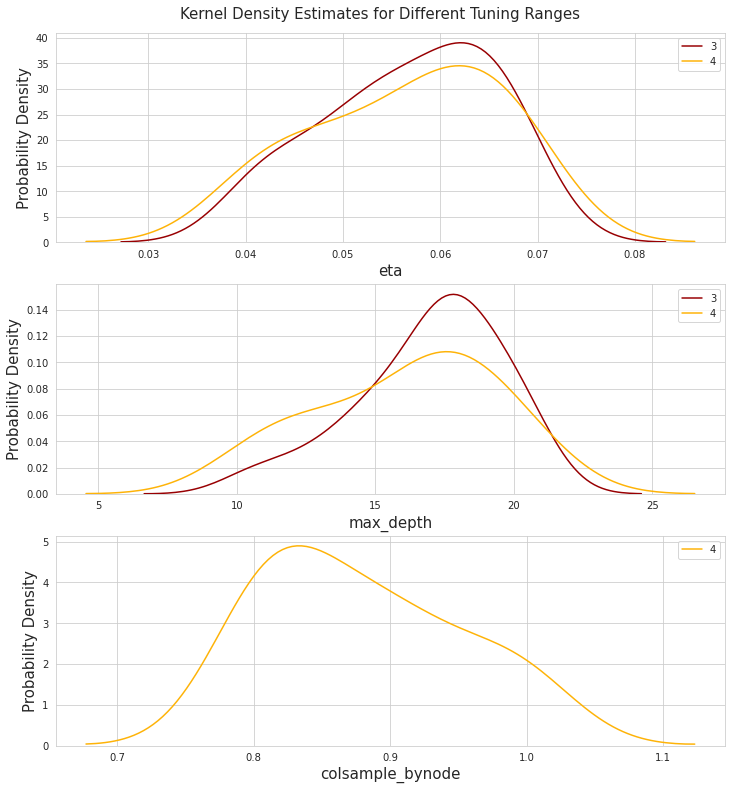

In [131]:
# assemble desired trial runs
_dict = {xgbr_trials_3: 3, 
         xgbr_trials_4: 4
        }
# plot the results, so far
plot_kde(_dict)

This distribution of hyperparameters selected did not change, significantly.

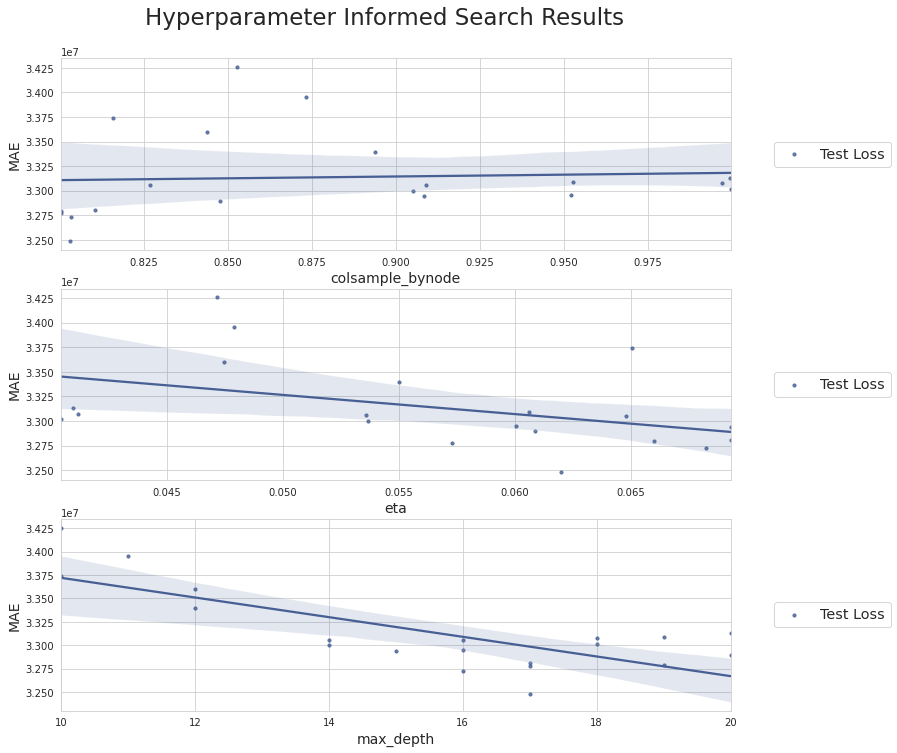

In [132]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_4)

Model performance remained strong at the higher end of the tree depth values.<br>
I will keep an eye on the eta range, as it appears that models using higher values perform better.

Next, I will allow the models to perform subsampling of the features at the creation of each tree.<br>
Below are the results of sampling between 50 and 100% of the features.

 > **colsample_bytree**

In [133]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']],
    'colsample_bytree': np.linspace(0.5, 1.0, 6), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.8029987229679669]
colsample_bytree [0.5 0.6 0.7 0.8 0.9 1. ]
eta [0.06200339576094763]
max_depth [17]


colsample_bytree : 0.5 ...
Test MAE: $33,244,497.00
Training MAE: $5,153,077.90
Average Boosting Rounds: 497

colsample_bytree : 0.6 ...
Test MAE: $32,995,869.80
Training MAE: $4,780,786.28
Average Boosting Rounds: 494

colsample_bytree : 0.7 ...
Test MAE: $32,936,118.60
Training MAE: $4,458,663.80
Average Boosting Rounds: 495

colsample_bytree : 0.8 ...
Test MAE: $33,116,922.60
Training MAE: $4,366,156.75
Average Boosting Rounds: 485

colsample_bytree : 0.9 ...
Test MAE: $32,940,904.20
Training MAE: $3,388,221.88
Average Boosting Rounds: 497

colsample_bytree : 1.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482



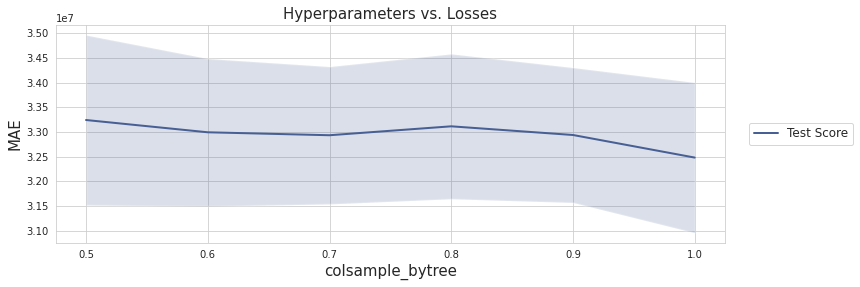

In [134]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [135]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


Once again, the models perform better with a larger subsampling.<br>
I will show the results of a search that uses between 90 and 100% of the features.

 > **xgbr_trials_4a**

In [136]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [137]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.9, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4a)
# save trials object
pickle.dump(xgbr_trials_4a, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_4a.pkl', 'wb'))

100%|██████████| 20/20 [23:34<00:00, 70.72s/trial, best loss: 32616429.6] 


In [138]:
# get results DataFrame
trials_4a_df = make_trials_df(xgbr_trials_4a)
trials_4a_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,colsample_bytree,eta,max_depth
9,1,1,10,32616429.6,5.688169e+06,496,0.853717,0.977009,0.048223,17
6,1,1,7,32708146.6,2.825489e+06,499,0.800377,0.960353,0.054187,20
14,1,2,15,32748660.2,2.850534e+06,494,0.887502,0.905726,0.058567,19
12,1,2,13,32827986.6,4.664172e+06,490,0.855679,0.981538,0.061928,15
19,1,2,20,32834087.0,6.966813e+06,493,0.801915,0.953174,0.044153,17
4,1,1,5,32838268.6,3.257394e+06,492,0.923020,0.967681,0.051099,20
7,1,1,8,32854541.4,2.183667e+06,453,0.801473,0.917750,0.069799,20
18,1,2,19,32876779.8,5.110918e+06,497,0.824594,0.969422,0.050492,17
17,1,2,18,32921000.8,2.833743e+06,496,0.825065,0.957962,0.054741,20
13,1,2,14,32931586.2,8.525220e+06,496,0.827253,0.942882,0.045548,15


In [139]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


There is no performance improvement when subsampling features at tree creation.

I will move on to the regularization hyperparameters.<br>
With decision trees, there are many other methods available to avoid model complexity.<br>
As such, standard L1 and L2 regularization may not be very helpful.<br>
I will include these hyperparameters in the search to be thorough.

The hyperparameter alpha is also known as L1 regularization.<br>
This value is subtracted from the gradient of the loss function, when calculating splits.<br>
It's default value is 0, meaning no regularization.<br>
I will search using values close to this.

 > **alpha**

In [140]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'alpha': np.linspace(0, 0.05, 6),
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

alpha [0.   0.01 0.02 0.03 0.04 0.05]
colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_depth [17]


alpha : 0.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

alpha : 0.01 ...
Test MAE: $32,840,657.00
Training MAE: $3,848,538.77
Average Boosting Rounds: 486

alpha : 0.02 ...
Test MAE: $32,763,003.60
Training MAE: $3,934,202.77
Average Boosting Rounds: 495

alpha : 0.03 ...
Test MAE: $32,944,620.60
Training MAE: $4,373,174.75
Average Boosting Rounds: 497

alpha : 0.04 ...
Test MAE: $32,823,521.40
Training MAE: $4,926,015.70
Average Boosting Rounds: 491

alpha : 0.05 ...
Test MAE: $33,018,016.00
Training MAE: $5,187,503.10
Average Boosting Rounds: 493



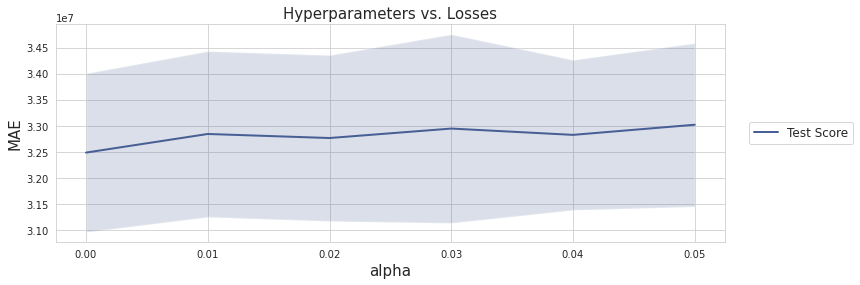

In [141]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [142]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


Using models without L1 regularization appears to be the best choice.<br>
I will demonstrate this below.

 > **xgbr_trials_4b**

In [143]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [144]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4b)
# save trials object
pickle.dump(xgbr_trials_4b, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_4b.pkl', 'wb'))

100%|██████████| 20/20 [27:48<00:00, 83.44s/trial, best loss: 32704964.0] 


In [145]:
# get results DataFrame
trials_4b_df = make_trials_df(xgbr_trials_4b)
trials_4b_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,alpha,colsample_bynode,eta,max_depth
6,1,1,7,32704964.0,1.475472e+06,492,0.000810,0.816598,0.068038,20
17,1,2,18,32705771.0,1.766499e+06,472,0.001210,0.802956,0.069831,20
7,1,1,8,32707391.6,1.699005e+06,471,0.000105,0.801473,0.069419,20
19,1,2,20,32791025.6,2.750165e+06,491,0.003586,0.825555,0.056867,20
18,1,2,19,32822407.0,4.100373e+06,472,0.004712,0.800334,0.066198,16
12,1,2,13,32875954.8,4.626398e+06,498,0.012032,0.881977,0.047130,20
14,1,2,15,33001145.8,2.794260e+06,473,0.010066,0.958844,0.064430,19
16,1,2,17,33030949.8,3.728476e+06,444,0.017275,0.913040,0.068004,19
1,1,1,2,33039208.6,7.547083e+06,498,0.029732,0.999713,0.040438,18
11,1,2,12,33044623.4,5.679084e+06,492,0.004876,0.856607,0.049389,17


In [146]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


I will leave this hyperparameter set to its default.

Next, I will use the lambda hyperparameter, called L2 regularization.<br>
This value is added to the hessian of the loss function, when determining node splits.<br>
It's default value is 1, which is no regularization.<br>
I will observe the results of using values for lambda on either side of the default value.

 > **lambda**

In [147]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'lambda': np.linspace(0.2, 1.6, 8),
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

lambda [0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_depth [17]


lambda : 0.2 ...
Test MAE: $32,970,361.00
Training MAE: $2,081,261.30
Average Boosting Rounds: 444

lambda : 0.4 ...
Test MAE: $33,033,520.80
Training MAE: $1,865,391.70
Average Boosting Rounds: 482

lambda : 0.6000000000000001 ...
Test MAE: $33,157,328.00
Training MAE: $2,320,747.85
Average Boosting Rounds: 483

lambda : 0.8 ...
Test MAE: $32,960,023.80
Training MAE: $2,676,459.30
Average Boosting Rounds: 488

lambda : 1.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

lambda : 1.2 ...
Test MAE: $32,895,233.00
Training MAE: $3,386,360.48
Average Boosting Rounds: 498

lambda : 1.4000000000000001 ...
Test MAE: $32,666,016.00
Training MAE: $4,040,401.12
Average Boosting Rounds: 493

lambda : 1.6 ...
Test MAE: $32,713,970.60
Training MAE: $4,671,682.35
Average Boosting Rounds: 486



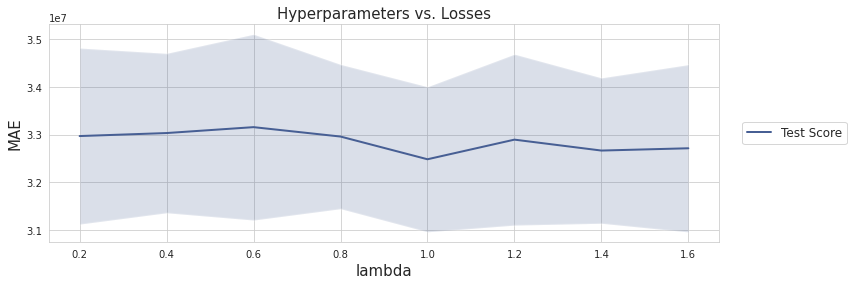

In [148]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [149]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


I will use values between 0.2 and 1.5 to find a good model.

 > **xgbr_trials_4c**

In [150]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [151]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'lambda': hp.uniform('lambda', 0.2, 1.5), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4c)
# save trials object
pickle.dump(xgbr_trials_4c, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_4c.pkl', 'wb'))

100%|██████████| 50/50 [17:39<00:00, 21.18s/trial, best loss: 32553161.8] 


In [152]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


After a very long run, I get nothing to show for it.

Along with eta to control complexity, the use of the Pseudo-Huber loss may have eliminated the need to use regularization.

Next, I will use the pseudo-regularization hyperparameter, gamma, also called the Lagrangian multiplier.<br>
Gamma is in charge of tree pruning.<br>
After the trees are grown, splits are eliminated that have a gain value that is less than gamma.<br>
Since gamma is directly compared to the gain value of the nodes, its effective value is data dependent.<br>
I will try a broar range of values.<br>
It's default value is 0, meaning it is turned off.

 > **gamma**

In [153]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'gamma': [0.1, 1, 10, 100, 1000],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
gamma [0.1, 1, 10, 100, 1000]
max_depth [17]


gamma : 0.1 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 1 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 10 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 100 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 1000 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482



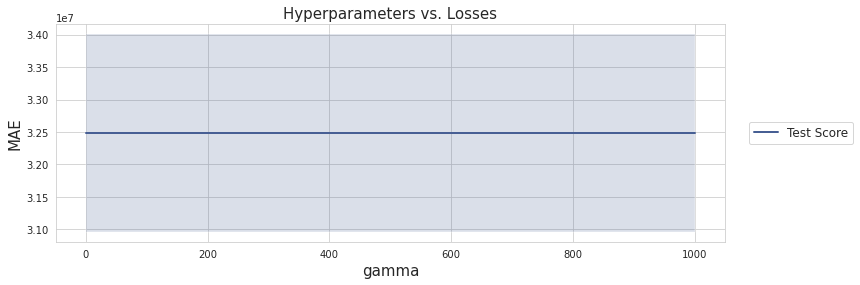

In [154]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [155]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


There is no effect on the model accuracy, using any of my chosen values for gamma.<br>
I will not do an informed search with this hyperparameter and will leave it at its default.

Finally, I will observe the effect of tuning the parameter max delta step.<br>
This is a value that, along with eta, determines the maximum value a leaf node can take.<br>
Where eta reduces a leaf score through a scale factor, max delta step puts an absolute cap on this value.<br>
It has a default value of 0, which turns it off.<br>
I will explore the range of values between 0.9 and 1.9.

 > **max_delta_step**

In [156]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_delta_step': np.linspace(0.9, 1.9, 6),
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_delta_step [0.9 1.1 1.3 1.5 1.7 1.9]
max_depth [17]


max_delta_step : 0.9 ...
Test MAE: $32,617,662.00
Training MAE: $10,026,210.10
Average Boosting Rounds: 497

max_delta_step : 1.1 ...
Test MAE: $32,342,058.80
Training MAE: $7,737,427.90
Average Boosting Rounds: 496

max_delta_step : 1.3 ...
Test MAE: $32,397,262.00
Training MAE: $6,311,312.65
Average Boosting Rounds: 499

max_delta_step : 1.5 ...
Test MAE: $32,356,094.40
Training MAE: $5,777,133.30
Average Boosting Rounds: 492

max_delta_step : 1.7 ...
Test MAE: $32,360,188.00
Training MAE: $5,132,884.90
Average Boosting Rounds: 498

max_delta_step : 1.9 ...
Test MAE: $32,596,780.20
Training MAE: $4,807,187.40
Average Boosting Rounds: 498



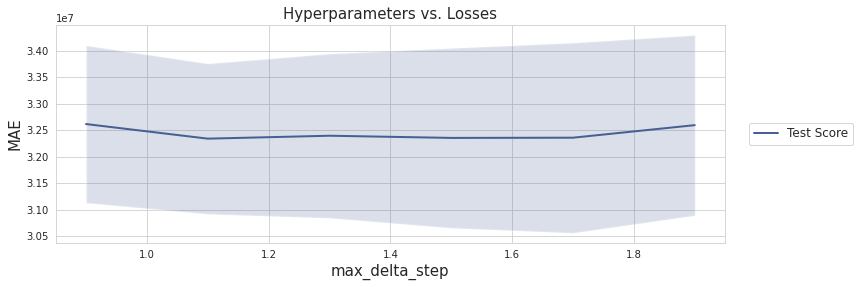

In [157]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [158]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


There is a wide range of values that give test scores that are lower than the best model, so far.

 > **xgbr_trials_5**

In [159]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [160]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5)
# save trials object
pickle.dump(xgbr_trials_5, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_5.pkl', 'wb'))

100%|██████████| 20/20 [20:04<00:00, 60.20s/trial, best loss: 31912026.6] 


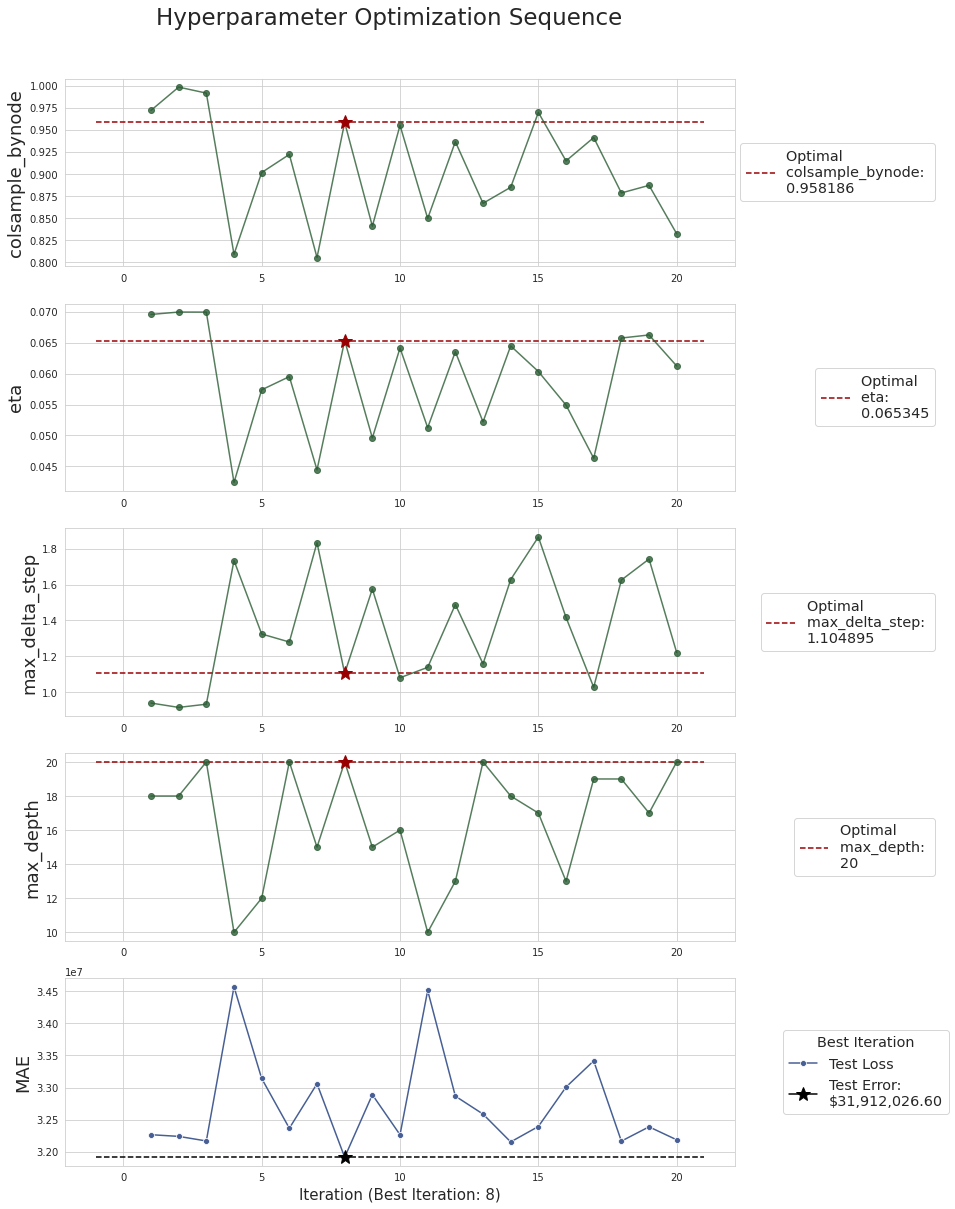

In [161]:
# plot informed search history
plot_param_search(xgbr_trials_5)

In [162]:
# get results DataFrame
trials_5_df = make_trials_df(xgbr_trials_5)
trials_5_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
7,1,1,8,31912026.6,4516115.650,496,0.958186,0.065345,1.104895,20
13,1,2,14,32151591.2,3995970.025,494,0.884897,0.064477,1.628700,18
17,1,2,18,32163953.6,3458149.325,492,0.878472,0.065757,1.625931,19
2,1,1,3,32166364.2,4610015.650,498,0.991444,0.069951,0.932457,20
19,1,2,20,32184444.6,5197457.100,498,0.832249,0.061229,1.220573,20
1,1,1,2,32237986.6,5996991.650,496,0.998212,0.069957,0.914589,18
9,1,1,10,32263621.2,7702878.150,497,0.954918,0.064139,1.080290,16
0,1,1,1,32264094.6,5899638.950,495,0.971885,0.069569,0.938970,18
5,1,1,6,32364937.6,5188144.200,496,0.922039,0.059511,1.279807,20
18,1,2,19,32387102.2,4232820.350,487,0.887050,0.066251,1.743254,17


In [163]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


The test loss has been reduce by over another half million dollars.

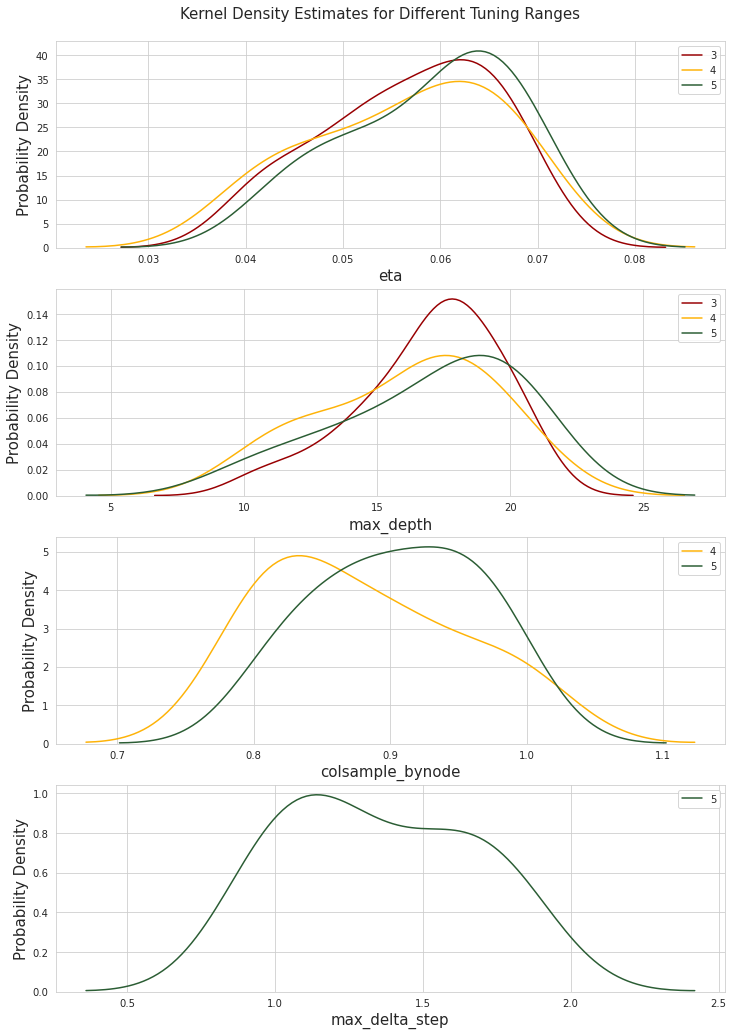

In [164]:
# assemble desired trial runs
_dict = {xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5
        }
# plot the results, so far
plot_kde(_dict)

The distibutions of selected hyperparameters look similar to those from the previous best trials.

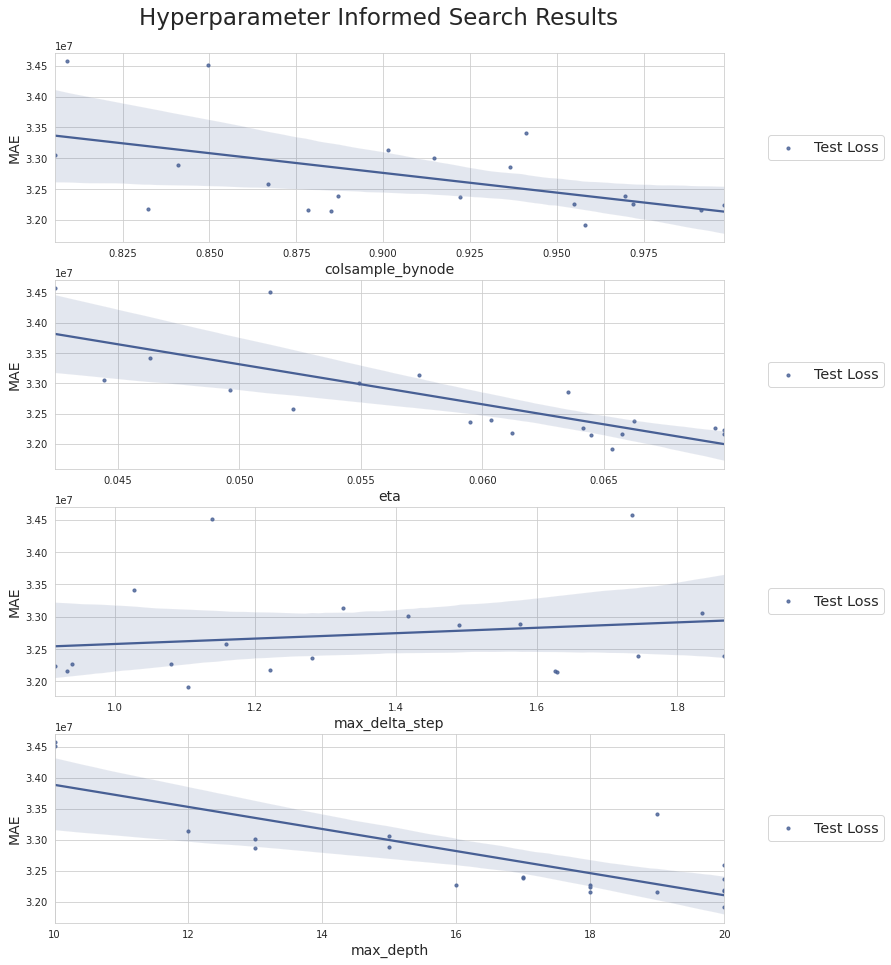

In [165]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_5)

The slopes of both the eta and the max depth plots are very steep.<br>
I attempted to adjust the ranges of these hyperparameters.<br>
I used a search grid to check values between 0.04 and 0.14 for eta, 20 and 25 for max depth.<br>
None of the resulting models had a test error below than 32 million dollars.<br>
After a few Hyperopt searches, I couldn't find a model that performed better than $31,940,000 by using those ranges.<br>
As these trials didn't yield a model that I wanted to use, I didn't include the analysis in the notebook.

Finally, I wanted to find out was how much model performance would change by varying the boosting parameters.<br>
I will start with observing the effects of changing the maximum number of boosting rounds.<br>
I am going to do a grid search for boosting round values between 300 and 1000.<br>
I will disable the early stopping limit, during the search.

 > **num_boost_round**

In [166]:
# get best hyperparameters from last trials
best_params = xgbr_trials_5.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'early_stopping_limit': [1000], 
    'eta': [best_params['eta']],
    'max_delta_step': [best_params['max_delta_step']],
    'max_boost_round': [int(x) for x in np.linspace(300, 1000, num=8)], 
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.95818635507785]
early_stopping_limit [1000]
eta [0.06534522748755471]
max_delta_step [1.1048948126486449]
max_boost_round [300, 400, 500, 600, 700, 800, 900, 1000]
max_depth [20]


max_boost_round : 300 ...
Test MAE: $35,173,587.00
Training MAE: $20,635,465.00
Average Boosting Rounds: 300

max_boost_round : 400 ...
Test MAE: $32,414,069.20
Training MAE: $9,058,928.40
Average Boosting Rounds: 399

max_boost_round : 500 ...
Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Average Boosting Rounds: 496

max_boost_round : 600 ...
Test MAE: $31,753,405.00
Training MAE: $2,377,663.65
Average Boosting Rounds: 587

max_boost_round : 700 ...
Test MAE: $31,709,016.20
Training MAE: $1,650,828.21
Average Boosting Rounds: 653

max_boost_round : 800 ...
Test MAE: $31,687,819.00
Training MAE: $1,330,912.33
Average Boosting Rounds: 711

max_boost_round : 900 ...
Test MAE: $31,682,559.00
Training MAE: $1,157,224.98
Average Boosting Rounds: 776

max_boost_round : 1000 ...
Test MAE: $31,678,760.00
Training MAE: $1,113,171.89
Average Boosting Rounds: 811



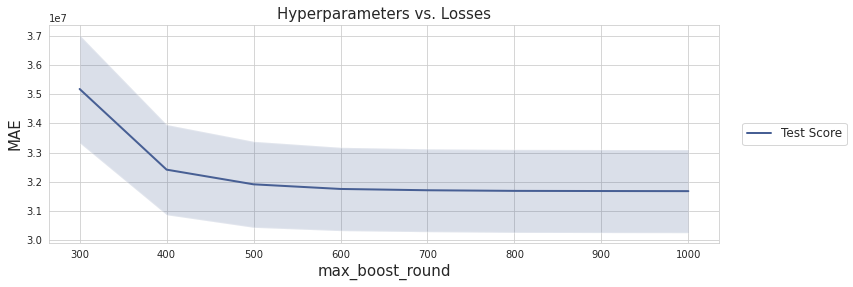

In [167]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

As expected, the errors decrease, as more boosting rounds are allowed.

Now, I will observe the effects of changing the early stopping rounds limit.<br>
The search will cover a range of values between 100 and 400 boosting rounds to observe any accuracy improvement.

 > **early_stopping_limit**

In [168]:
# get best hyperparameters from last trials
best_params = xgbr_trials_5.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'early_stopping_limit': [int(x) for x in np.linspace(100, 400, num=4)], 
    'eta': [best_params['eta']],
    'max_delta_step': [best_params['max_delta_step']],
    'max_boost_round': [1000], 
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.95818635507785]
early_stopping_limit [100, 200, 300, 400]
eta [0.06534522748755471]
max_delta_step [1.1048948126486449]
max_boost_round [1000]
max_depth [20]


early_stopping_limit : 100 ...
Test MAE: $31,680,362.60
Training MAE: $1,159,272.25
Average Boosting Rounds: 790

early_stopping_limit : 200 ...
Test MAE: $31,678,760.00
Training MAE: $1,113,171.89
Average Boosting Rounds: 811

early_stopping_limit : 300 ...
Test MAE: $31,678,760.00
Training MAE: $1,113,171.89
Average Boosting Rounds: 811

early_stopping_limit : 400 ...
Test MAE: $31,678,760.00
Training MAE: $1,113,171.89
Average Boosting Rounds: 811



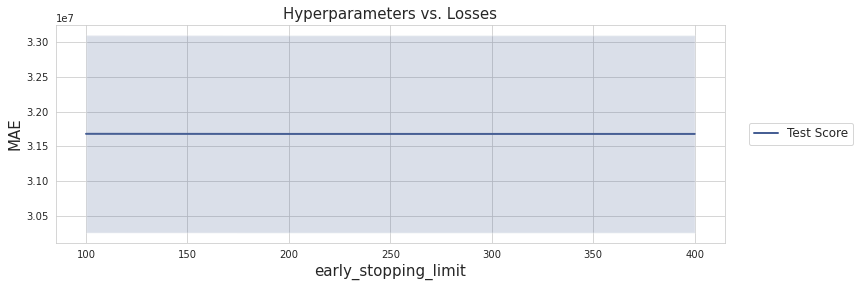

In [169]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

The best training parameter values are 200 for early stopping rounds and 1000 for the boosting round limit.<br>
This ignores potential concerns about computational costs, as growing 1000 trees per ensemble is unconventional.

 > **xgbr_trials_6**

In [170]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_6 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [171]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_6, 
                  max_boost_round=1000, early_stopping_limit=200)
# save trials object
pickle.dump(xgbr_trials_6, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_6.pkl', 'wb'))

100%|██████████| 20/20 [42:26<00:00, 127.31s/trial, best loss: 31775035.6]  


The trials take at least twice as long to run.

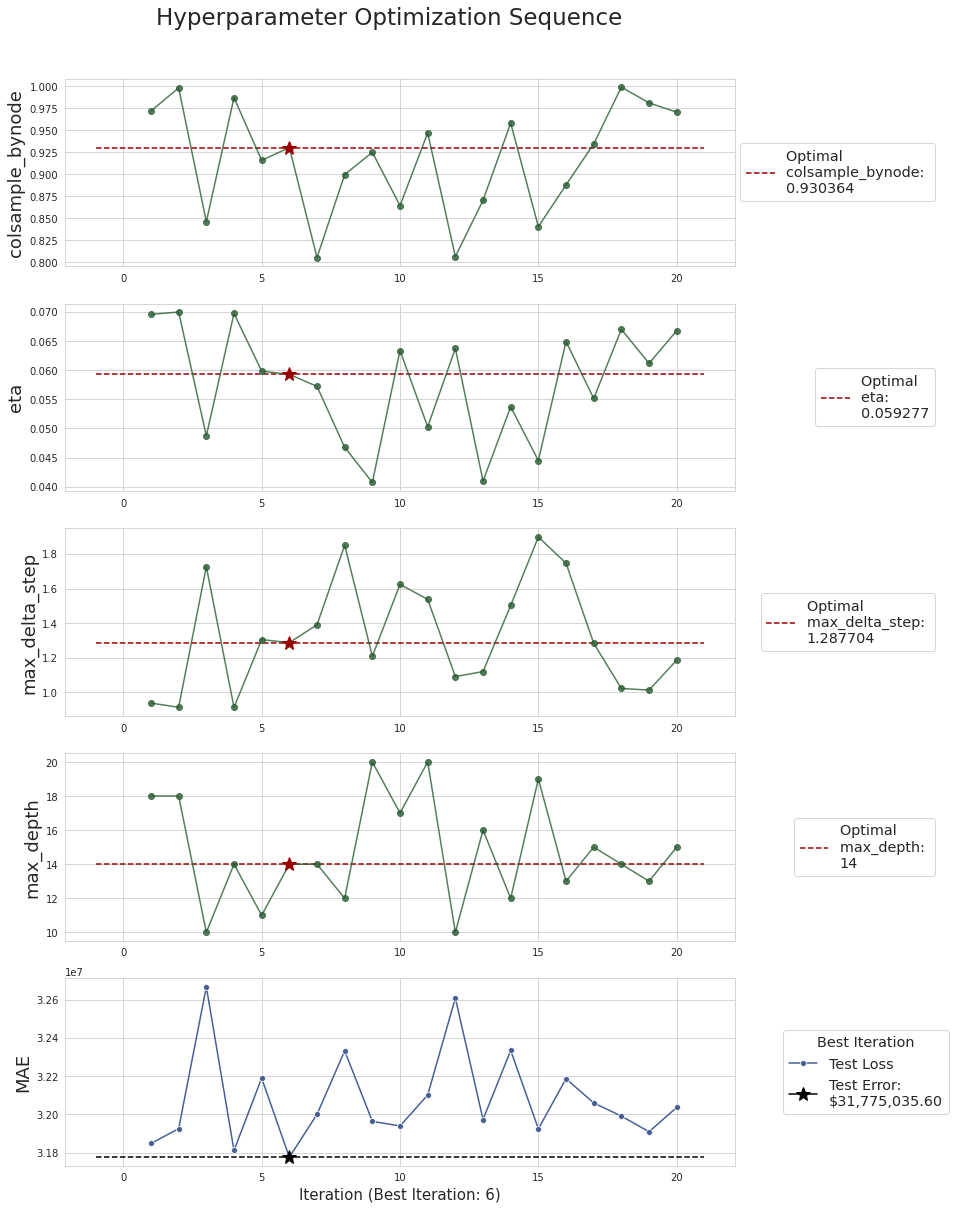

In [172]:
# plot informed search history
plot_param_search(xgbr_trials_6)

The optimal hyperparameters are all in the middle of their respective ranges.<br>
Notably, the best tree depth has decreased to 14.

In [173]:
# get results DataFrame
trials_6_df = make_trials_df(xgbr_trials_6)
trials_6_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
5,1,1,6,31775035.6,1.481423e+06,963,0.930364,0.059277,1.287704,14
3,1,1,4,31810858.8,1.625204e+06,922,0.987069,0.069717,0.913997,14
0,1,1,1,31847541.8,5.740246e+05,851,0.971885,0.069569,0.938970,18
18,1,2,19,31908747.8,2.493581e+06,955,0.981152,0.061154,1.013813,13
14,1,2,15,31923993.0,9.538072e+05,990,0.840472,0.044486,1.897209,19
1,1,1,2,31924544.6,9.038368e+05,821,0.998212,0.069957,0.914589,18
9,1,1,10,31938893.6,7.025479e+05,859,0.864337,0.063359,1.623840,17
8,1,1,9,31963055.0,1.796548e+06,981,0.925031,0.040730,1.209148,20
12,1,2,13,31972701.4,3.583320e+06,993,0.870322,0.040974,1.120675,16
17,1,2,18,31990425.2,1.963245e+06,892,0.999054,0.066993,1.023217,14


There are 4 models with better test scores, than the last best model.

In [174]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


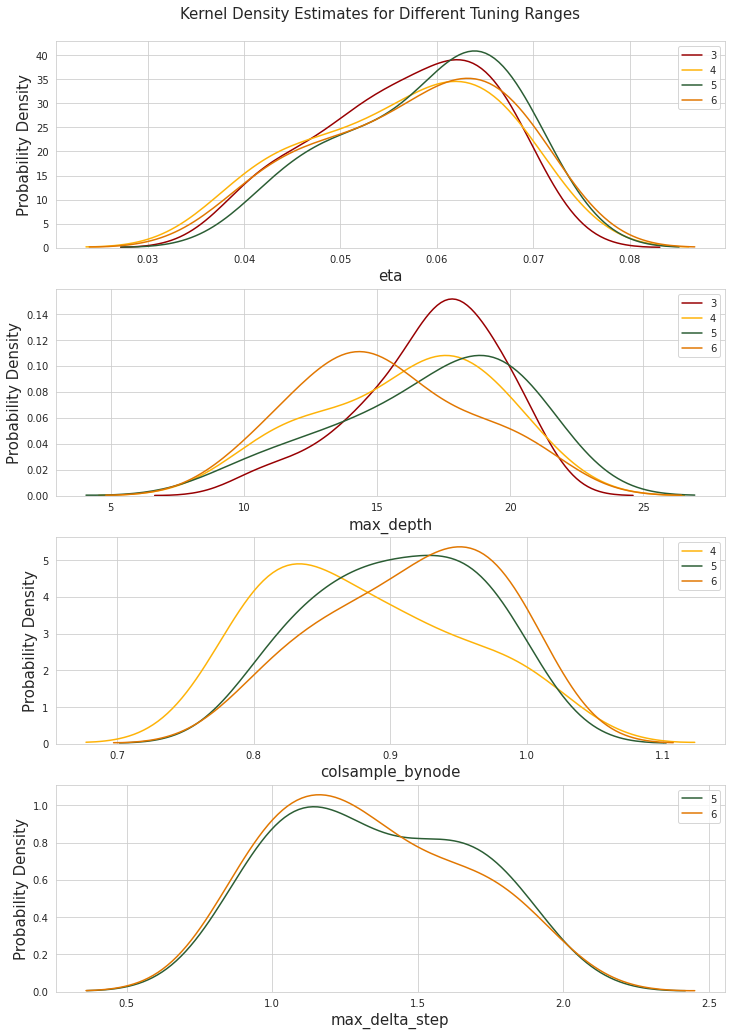

In [175]:
# assemble desired trial runs
_dict = {xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6
        }
# plot the results, so far
plot_kde(_dict)

The hyperparameter choice distributions look bell balanced.

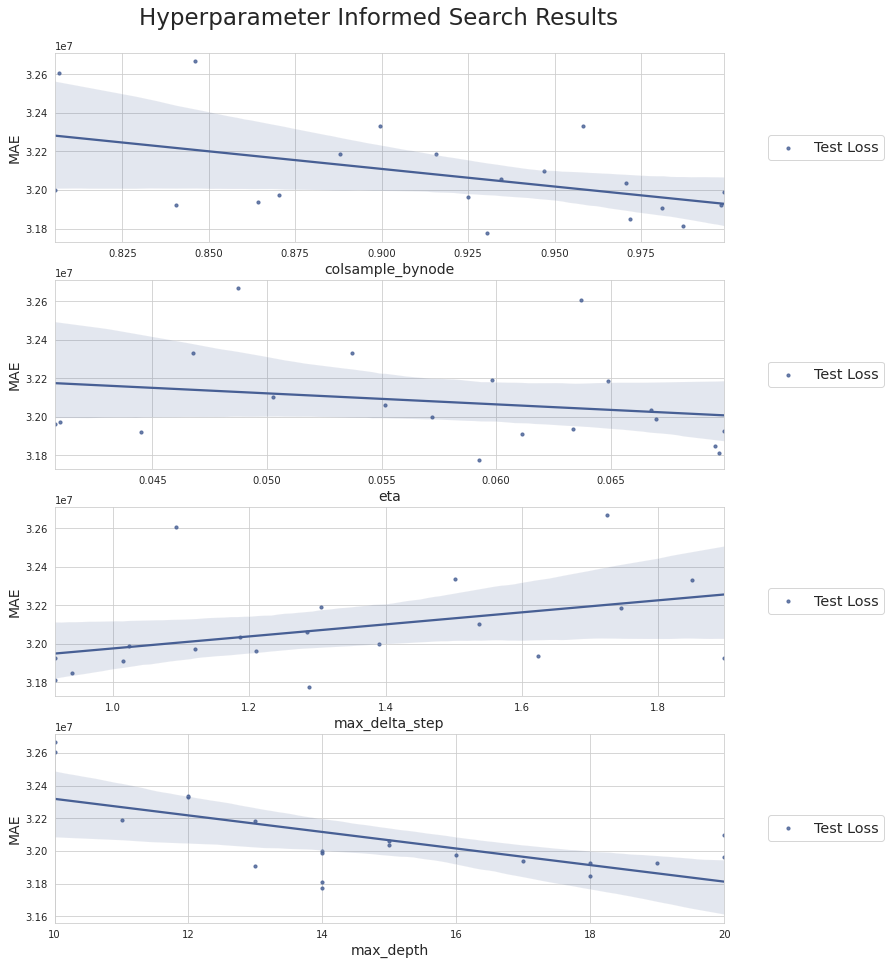

In [176]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_6)

The slope of the eta plot looks less extreme.<br>
This means that the errors are closer to each other for different values of eta.

In [177]:
# observe metrics of best trial from this trials object
print_best_trial(xgbr_trials_6)

Test MAE: $31,775,035.60
Training MAE: $1,481,422.60
Num Boosters: 963


Although I found a better model than any I had gotten in previous trials, the best one was seen in the last grid search.<br>
The model with the trials 5 hyperparameters got a test error of $31,678,760.00, through using the larger boosting values.<br>
I can get all of these parameters into a trials object, which can be exported for making predictions, downstream.

 > **xgbr_trials_7**

In [178]:
# get best hyperparameters from trials 5
best_params = xgbr_trials_5.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_delta_step': [best_params['max_delta_step']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.95818635507785]
eta [0.06534522748755471]
max_delta_step [1.1048948126486449]
max_depth [20]


In [179]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [180]:
# create informed search space using one value per hyperparameter for one evaluation
hp_space = {
    'colsample_bynode': hp.choice(
        'colsample_bynode', [best_params['colsample_bynode'], 
                              best_params['colsample_bynode']]), 
    'eta': hp.choice(
        'eta', [best_params['eta'], 
                best_params['eta']]), 
    'max_delta_step': hp.choice(
        'max_delta_step', [best_params['max_delta_step'], 
                      best_params['max_delta_step']]), 
    'max_depth': hp.choice(
        'max_depth', [best_params['max_depth'], 
                      best_params['max_depth']]) 
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=10, cv_type=get_scratch_cv, processor_type='gpu_hist', 
                         max_boost_round=1000, early_stopping_limit=200)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_7, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_7, open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_7.pkl', 'wb'))

100%|██████████| 1/1 [06:48<00:00, 408.59s/trial, best loss: 31678760.0]


In [181]:
# get results DataFrame
trials_7_df = make_trials_df(xgbr_trials_7)
trials_7_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
0,0,0,1,31678760.0,1.113172e+06,811,0.958186,0.065345,1.104895,20


In [182]:
# observe metrics of best trial from best trials object
print_best_trial(xgbr_trials_7)

Test MAE: $31,678,760.00
Training MAE: $1,113,171.89
Num Boosters: 811


Now I can step back and observe the journey to this final model.

In [183]:
def join_losses(trials_dict):
    """Extracts loss and hyperparameters for best estimator of each trials object"""
    # specify columns to extract
    loss_cols = ['loss', 'train_mae']
    # instantiate empty DataFrame
    df = pd.DataFrame()
    # iterate through trials objects
    for key, value in trials_dict.items():
        # extract metrics
        loss_df = pd.DataFrame(
            key.best_trial['result'], index=[value], columns=loss_cols)
        # extract parameters for best estimator of each trial session
        params_df = pd.DataFrame(
            key.best_trial['result']['params'], index=[value])
        # put it all together
        trials_df = loss_df.join(params_df)
        df = pd.concat([df, trials_df])
        df.reset_index()
        
    return df

In [184]:
def plot_metrics(trials_dict):
    """Plot test loss for best ensembles"""
    # construct DataFrame
    df = join_losses(trials_dict)
    # plot loss metric
    sns.lineplot(x=df.index, y='loss', data=df, label='Test Loss')
    
    plt.xlabel('Trials', fontsize=15)
    plt.ylabel('MAE', fontsize=15)

    plt.legend(fontsize='x-large')
    plt.title('Mean Absolute Error for Best Ensemble of Each Trial', 
              fontsize=15, y=1.05)

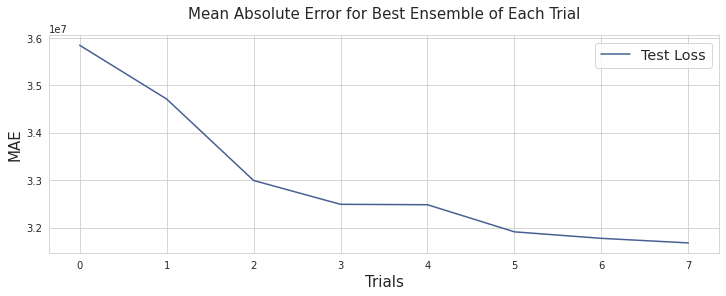

In [185]:
# assemble all trial runs
trials_dict = {xgbr_trials_0: 0, 
               xgbr_trials_1: 1, 
               xgbr_trials_2: 2, 
               xgbr_trials_3: 3, 
               xgbr_trials_4: 4, 
               xgbr_trials_5: 5, 
               xgbr_trials_6: 6, 
               xgbr_trials_7: 7
              }
# plot the results
plot_metrics(trials_dict)

The test loss decreased by an additional 10%, through hyperparameter tuning.<br>
With the 13% improvement from using the Pseudo-Huber loss, the test error was improved by over 23% in this notebook.

I will take a look at the feature importance for the predictions

In [186]:
def plot_feature_importance(features, target, importance_type, trials=None, params={}, 
                            max_boost_round=500, early_stopping_limit=100):
    """Plot predictors by chosen importance to model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get hyperparameters from trials object
    if trials:
        params = trials.best_trial['result']['params']
    # get model
    model = get_xgbr_train(dtrain, dtest, 10, 'gpu_hist', params=params, 
                           max_boost_round=max_boost_round, 
                           early_stopping_limit=early_stopping_limit)[0]
    # create dict to hold feature importance
    importance_dict = model.get_score(importance_type=importance_type)
    # sort feature importance by ascending values values
    sorted_importance_dict = {
        k: v for k, v in sorted(
            importance_dict.items(), key=lambda item: item[1], reverse=True)}
    # plot feature importance
    sns.barplot(x=list(sorted_importance_dict.keys()), 
                y=list(sorted_importance_dict.values()), 
                palette=my_palette).set_xticklabels(sorted_importance_dict.keys(), 
                                                    rotation=70)
    
    plt.xlabel('Predictor', fontsize=20, labelpad=15)
    plt.ylabel('Average ' + importance_type.capitalize(), fontsize=15, labelpad=15)
    
    plt.title('Feature Importance', fontsize=20, y=1.05)

First, I will observe the way that the untuned model used the predictors.

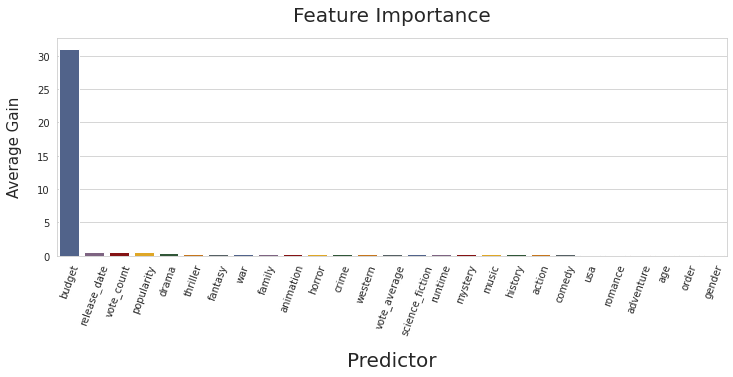

In [187]:
# plot feature importance by selected metric for base model
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_0)

It appears that this model decided it was best to primarily use one independent variable for predicting.

Now, here's what happened after I lowered the eta value.

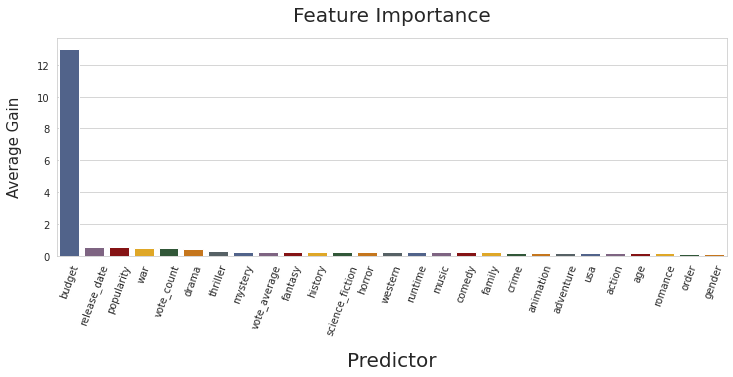

In [188]:
# plot feature importance by selected metric for base model
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_1)

It doesn't appear like much has changed, except that the extent of the y-axis is cut in half.

Here, I increased the tree depths.

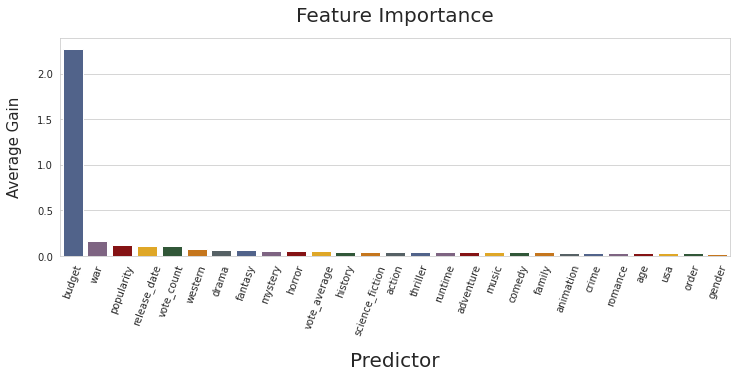

In [189]:
# plot feature importance by selected metric for base model
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_2)

The gain scale has been reduced by one sixth, although the budget is still the major predictor for deciding to split.

At this point, I retuned the eta.<br>
The vote count feature is becoming more important.

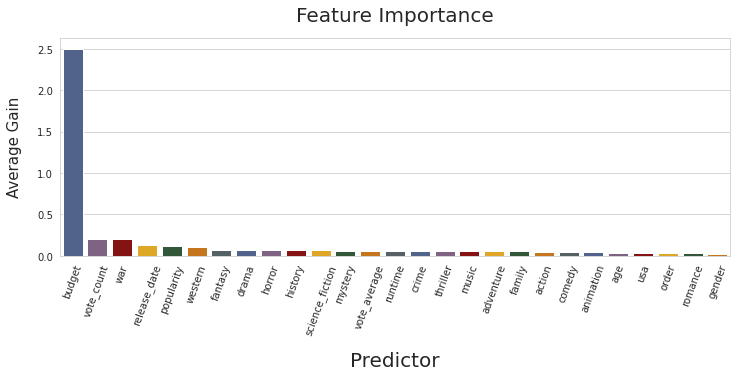

In [190]:
# plot feature importance by selected metric for base model
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_3)

This is when the model began to use feature subsampling.

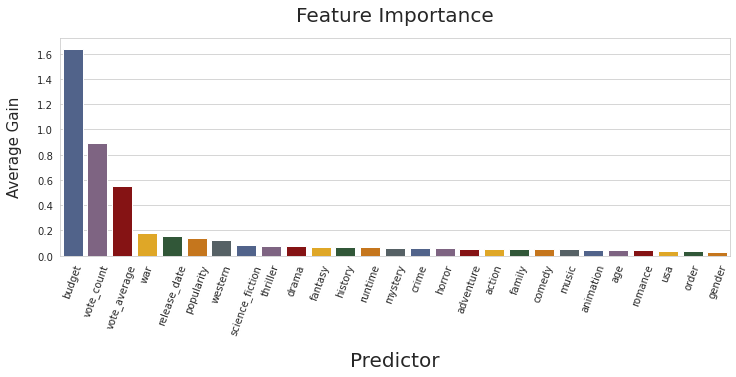

In [191]:
# plot feature importance by selected metric for base model
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_4)

The model has grown much more complex.<br>
This may explain the reason for the large increase in computation time.

This is the point where the leaf score cap was set by the max delta step hyperparameter.

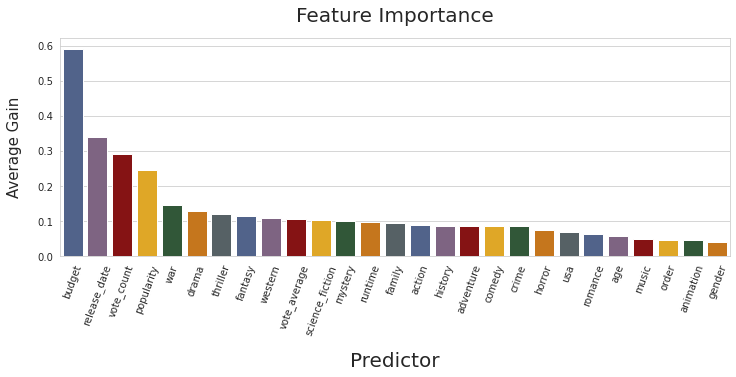

In [192]:
# plot feature importance by selected metric for best model using 500 boosting rounds
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_5)

This model was spening a lot of that extra training time being forced to learn using a wider range of the features.<br>
The value of the gain with respect to each feature is on the same scale, now.

Finally, I'll check to see how this model used the extra 500 boosting rounds, with the longer early stopping window.

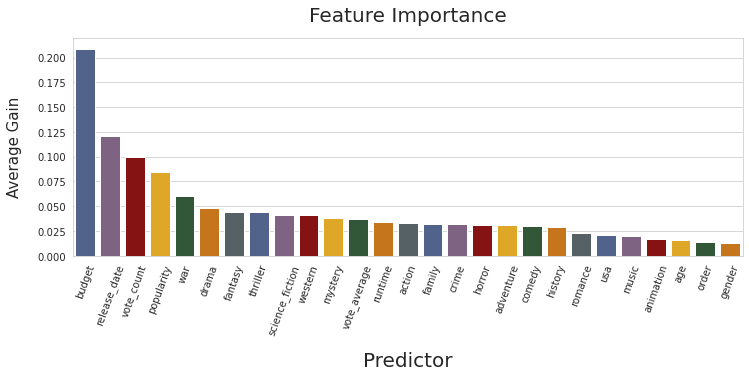

In [193]:
# plot feature importance by selected metric for best model using 1000 boosting rounds
plot_feature_importance(X_train, y_train, 'gain', xgbr_trials_7, 
                        max_boost_round=1000, early_stopping_limit=200)

This model had a slightly different order of predictor importance than the one that was trained more quickly.<br>
Once again, it is important to notice that the scale of the gain values has decreased by another one third.

 > **XGBoost Final Evaluation**

First, I'll see what the error of base model would have been, without any hyperparameter tuning.

In [194]:
def print_validation_results(X, y, trials=None, params={}, 
                             max_boost_round=500, early_stopping_limit=100):
    """Print final validation error & percent difference between training and validation"""
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=27)
    # get hyperparameters from trials object
    if trials:
        params = trials.best_trial['result']['params']
    # get validation error
    test_results = get_scratch_cv(X_test, y_test, 10, 'gpu_hist', params=params, 
                                  max_boost_round=max_boost_round, 
                                  early_stopping_limit=early_stopping_limit)
    # average score over folds
    test_mae = np.mean(test_results['test_mae'])
    
    print('Validation Error: {}'.format(make_money(test_mae)))

In [195]:
# get validation results without tuning (base model)
print_validation_results(X, y)

Validation Error: $41,609,877.60


The base model's error on the validation data is $41,609,877.60.

Now, I'll find out how the best tuned model performs on the validation set.

In [196]:
# get validation results on best tuned model
print_validation_results(X, y, xgbr_trials_7, 
                         max_boost_round=1000, early_stopping_limit=200)

Validation Error: $38,963,668.20


Hyperparameter tuning using an informed search algorithm has improved the validation error by nearly $2,650,000 dollars.